In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from soupsieve.util import lower

In [3]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# customers_dataset

In [4]:
customers_df = pd.read_csv('data/olist_customers_dataset.csv')
customers_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
customers_df.shape

(99441, 5)

In [6]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [7]:
# 전체 주문 건수: 99,441건
customers_df['customer_id'].nunique()

99441

In [8]:
# 고유 고객 수: 96,096명
customers_df['customer_unique_id'].nunique()

96096

In [9]:
unique_customer_df = customers_df.groupby('customer_unique_id').agg({
    'customer_id': 'count',
    'customer_city': 'nunique',
    'customer_state': 'nunique'
}).reset_index()

unique_customer_df.columns = ['customer_unique_id', 'unique_order_count', 'unique_city_count', 'unique_state_count']

In [10]:
unique_customer_df['unique_order_count'].unique()

array([ 1,  2,  3,  4,  6,  7,  5,  9, 17])

In [11]:
unique_customer_df['unique_order_count'].value_counts()

unique_order_count
1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: count, dtype: int64

In [12]:
unique_customer_df[unique_customer_df['unique_order_count'] > 4]

,customer_unique_id,unique_order_count,unique_city_count,unique_state_count
7175,12f5d6e1cbf93dafd9dcc19095df0b3d,6,1,1
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7,1,1
20337,35ecdf6858edc6427223b64804cf028e,5,1,1
21578,394ac4de8f3acb14253c177f0e15bc58,5,1,1
23472,3e43e6105506432c953e165fb2acf44c,9,1,1
27043,47c1a3033b8b77b3ab6e109eb4d5fdf3,6,1,1
29512,4e65032f1f574189fb793bac5a867bbc,5,1,1
32664,56c8638e7c058b98aae6d74d2dd6ea23,5,1,1
35628,5e8f38a9a1c023f3db718edcf926a2db,5,1,1
37585,63cfc61cee11cbe306bff5857d00bfe4,6,1,1


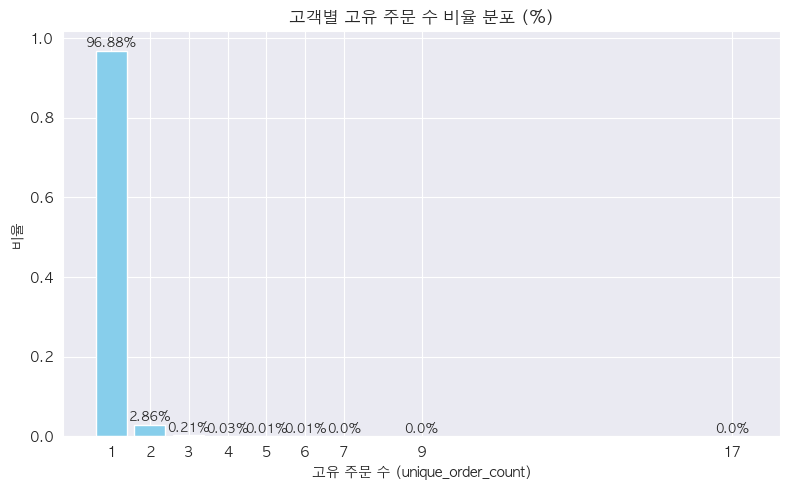

In [13]:
# 비율 계산
order_counts = unique_customer_df['unique_order_count'].value_counts(normalize=True).sort_index()
percentages = (order_counts * 100).round(2)  # 소수점 둘째 자리까지

# 시각화
plt.figure(figsize=(8, 5))
bars = plt.bar(order_counts.index, order_counts.values, color='skyblue')

# 라벨 및 제목
plt.xlabel('고유 주문 수 (unique_order_count)')
plt.ylabel('비율')
plt.title('고객별 고유 주문 수 비율 분포 (%)')
plt.xticks(order_counts.index)

# 막대 위에 비율 표시
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005,
             f"{percentages.iloc[i]}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [14]:
# 재구매 고객 수: 2,997명
unique_customer_df = unique_customer_df.sort_values('unique_order_count', ascending=False)
multi_order_customers = unique_customer_df[unique_customer_df['unique_order_count'] > 1]
print(multi_order_customers['customer_unique_id'].count())

# 도시 2개 이상 고객 수: 122명
multi_city_customers = unique_customer_df[unique_customer_df['unique_city_count'] > 1]
print(multi_city_customers['customer_unique_id'].count())

# 주 2개 이상 고객 수: 39명
multi_state_customers = unique_customer_df[unique_customer_df['unique_state_count'] > 1]
print(multi_state_customers['customer_unique_id'].count())

2997
122
39


## 2회 이상 구매 고객 필터링

In [15]:
filtered_customers = customers_df[customers_df['customer_unique_id'].isin(multi_order_customers['customer_unique_id'])]

filtered_customers.shape

(6342, 5)

In [16]:
# 고유 주(state) 수: 27
filtered_customers['customer_state'].nunique()

27

In [17]:
# 전체 주문 건수의 80%를 차지하는 state 비중
state_counts = filtered_customers['customer_state'].value_counts().sort_values(ascending=False)
total_customers = state_counts.sum()
cumsum_customers = state_counts.cumsum()
top_states_mask = cumsum_customers <= total_customers * 0.8
top_states_count = top_states_mask.sum()

total_states = state_counts.shape[0]
top_states_ratio = top_states_count / total_states * 100

print(f"전체 주문 건수의 80%를 차지하는 state 수: {top_states_count}개")
print(f"전체 state 수 중 비율: {top_states_ratio:.2f}%")

전체 주문 건수의 80%를 차지하는 state 수: 5개
전체 state 수 중 비율: 18.52%


In [18]:
# 전체 주문 건수의 80%를 차지하는 state 리스트
state_cumsum_ratio = state_counts.cumsum() / state_counts.sum()
top_states = state_cumsum_ratio[state_cumsum_ratio <= 0.8].index.tolist()

print(f"전체 주문 건수의 80%를 차지하는 주 리스트:\n{top_states}")
# ['SP', 'RJ', 'MG', 'RS', 'PR']
# [상파울루, 리우데자네이루, 미나스제라이스, 리오그란데두술, 파라나]

전체 주문 건수의 80%를 차지하는 주 리스트:
['SP', 'RJ', 'MG', 'RS', 'PR']


In [19]:
customer_ratio_by_state = state_counts / total_customers
customer_ratio_by_state['SP'].round(2)

0.43

# geolocation_dataset

In [20]:
geolocation_df = pd.read_csv('data/olist_geolocation_dataset.csv')
geolocation_df.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [21]:
geolocation_df.shape

(1000163, 5)

In [22]:
geolocation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [23]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [24]:
# 전체 주문 건수의 80%를 차지하는 state 시각화
import folium

# 주별 중심 도시 위치 정보 (주 약어 -> [위도, 경도])
state_coords = {
    'SP': [-23.5505, -46.6333],  # São Paulo
    'RJ': [-22.9068, -43.1729],  # Rio de Janeiro
    'MG': [-19.9167, -43.9345],  # Belo Horizonte
    'RS': [-30.0346, -51.2177],  # Porto Alegre
    'PR': [-25.4284, -49.2733],  # Curitiba
}

# 주 이름 매핑
state_names = {
    'SP': 'São Paulo',
    'RJ': 'Rio de Janeiro',
    'MG': 'Minas Gerais',
    'RS': 'Rio Grande do Sul',
    'PR': 'Paraná',
}

# 고객 비율
cust_count = {
    'SP': customer_ratio_by_state['SP'].round(2),
    'RJ': customer_ratio_by_state['RJ'].round(2),
    'MG': customer_ratio_by_state['MG'].round(2),
    'RS': customer_ratio_by_state['RS'].round(2),
    'PR': customer_ratio_by_state['PR'].round(2)
}

# 중심 좌표는 브라질 중앙 근처
m = folium.Map(location=[-15.7885, -47.8799], zoom_start=4)

# 마커 표시 (비중에 비례한 반지름으로)
for state_code, coords in state_coords.items():
    percentage = cust_count[state_code]
    radius = percentage * 100  # 반지름 조정 (예: 0.42 → 42)
    folium.CircleMarker(
        location=coords,
        radius=radius,
        popup=f"{state_names[state_code]}: {percentage:.2f}%",
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(m)

    # 주 이름 텍스트 레이블 추가
    folium.Marker(
        location=[coords[0] + 0.5, coords[1] + 0.5],  # 위치 약간 위로 조정
        icon=folium.DivIcon(html=f'<div style="font-size:10pt; font-weight:bold">{state_names[state_code]}</div>')
    ).add_to(m)

m

# order_items_dataset

In [25]:
order_items_df = pd.read_csv('data/olist_order_items_dataset.csv')
order_items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [26]:
order_items_df.shape

(112650, 7)

In [27]:
# 날짜 데이터 형변환 필요
order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [28]:
# 고유 판매자 수: 3,095명
order_items_df['seller_id'].nunique()

3095

In [29]:
# 판매자별 매출
order_items_df.groupby('seller_id')['price'].sum().sort_values(ascending=False)

seller_id
4869f7a5dfa277a7dca6462dcf3b52b2    229472.63
53243585a1d6dc2643021fd1853d8905    222776.05
4a3ca9315b744ce9f8e9374361493884    200472.92
fa1c13f2614d7b5c4749cbc52fecda94    194042.03
7c67e1448b00f6e969d365cea6b010ab    187923.89
                                      ...    
34aefe746cd81b7f3b23253ea28bef39         8.00
702835e4b785b67a084280efca355756         7.60
1fa2d3def6adfa70e58c276bb64fe5bb         6.90
77128dec4bec4878c37ab7d6169d6f26         6.50
cf6f6bc4df3999b9c6440f124fb2f687         3.50
Name: price, Length: 3095, dtype: float64

In [30]:
# 매출 80% 판매자 비중
seller_revenue = order_items_df.groupby('seller_id')['price'].sum().sort_values(ascending=False)
total_revenue = seller_revenue.sum()
threshold = total_revenue * 0.80  # 매출 80%

cumsum_revenue = seller_revenue.cumsum()
top_sellers_mask = cumsum_revenue <= threshold
top_sellers_count = top_sellers_mask.sum()

total_sellers = seller_revenue.shape[0]
top_sellers_ratio = top_sellers_count / total_sellers * 100

print(f"총 매출의 80%를 차지하는 판매자 수: {top_sellers_count}명")
print(f"전체 판매자 중 비중: {top_sellers_ratio:.2f}%")

총 매출의 80%를 차지하는 판매자 수: 543명
전체 판매자 중 비중: 17.54%


# sellers_dataset

In [31]:
sellers_df = pd.read_csv('data/olist_sellers_dataset.csv')
sellers_df.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [32]:
sellers_df.shape

(3095, 4)

In [33]:
sellers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [34]:
# 전체 판매자 수의 80%를 차지하는 state 시각화
state_counts = sellers_df['seller_state'].value_counts().sort_values(ascending=False)
total_sellers = state_counts.sum()
cumsum_sellers = state_counts.cumsum()
top_states_mask = cumsum_sellers <= total_sellers * 0.8
top_states_count = top_states_mask.sum()

total_states = state_counts.shape[0]
top_states_ratio = top_states_count / total_states * 100

print(f"전체 판매자 수의 80%를 차지하는 state 수: {top_states_count}개")
print(f"전체 state 수 중 비율: {top_states_ratio:.2f}%")

전체 판매자 수의 80%를 차지하는 state 수: 3개
전체 state 수 중 비율: 13.04%


In [35]:
# 전체 판매자 수의 80%를 차지하는 state 리스트
state_cumsum_ratio = state_counts.cumsum() / state_counts.sum()
top_states = state_cumsum_ratio[state_cumsum_ratio <= 0.8].index.tolist()

print(f"전체 판매자 수의 80%를 차지하는 주 리스트:\n{top_states}")
# ['SP', 'PR', 'MG']
# [상파울루, 파라나, 미나스제라이스]

전체 판매자 수의 80%를 차지하는 주 리스트:
['SP', 'PR', 'MG']


In [36]:
seller_ratio_by_state = state_counts / total_sellers
seller_ratio_by_state['SP'].round(2)

0.6

In [37]:
# 전체 판매자 수의 80%를 차지하는 state 시각화
# 'SP', 'PR', 'MG' 주별 판매자 비율 딕셔너리
seller_ratio = {
    'SP': seller_ratio_by_state['SP'].round(2),
    'PR': seller_ratio_by_state['PR'].round(2),
    'MG': seller_ratio_by_state['MG'].round(2)
}

# 주별 중심 도시 좌표
state_coords = {
    'SP': [-23.5505, -46.6333],  # São Paulo
    'PR': [-25.4284, -49.2733],  # Curitiba
    'MG': [-19.9167, -43.9345],  # Belo Horizonte
}

# Folium 지도 생성
m = folium.Map(location=[-20.0, -47.0], zoom_start=5)

# 원 크기를 비례하게 설정하여 지도에 표시
for state, percentage in seller_ratio.items():
    coords = state_coords[state]
    radius = percentage * 100  # 예: 0.42 → 42

    folium.CircleMarker(
        location=coords,
        radius=radius,
        popup=f"{state}: {percentage*100:.2f}%",
        tooltip=state,
        color='darkblue',
        fill=True,
        fill_color='skyblue',
        fill_opacity=0.7
    ).add_to(m)

    # 주 이름 텍스트 레이블 추가
    folium.Marker(
        location=[coords[0] + 0.5, coords[1] + 0.5],  # 위치 약간 위로 조정
        icon=folium.DivIcon(html=f'<div style="font-size:10pt; font-weight:bold">{state_names[state]}</div>')
    ).add_to(m)

m

# order_payments_dataset

In [38]:
order_payments_df = pd.read_csv('data/olist_order_payments_dataset.csv')
order_payments_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [39]:
order_payments_df.shape

(103886, 5)

In [40]:
order_payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [41]:
# 결제 수단별 빈도
order_payments_df['payment_type'].value_counts()
# credit_card: 신용카드
# boleto: 청구서 (브라질 특유의 결제 방식 - 은행 고지서 방식)
# voucher: 상품권/바우처
# debit_card: 체크카드
# not_defined: 미정

payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64

In [42]:
# 결제 수단별 결제금액 합계
order_payments_df.groupby('payment_type')['payment_value'].sum().sort_values(ascending=False)

payment_type
credit_card    12542084.19
boleto          2869361.27
voucher          379436.87
debit_card       217989.79
not_defined           0.00
Name: payment_value, dtype: float64

In [43]:
# 할부 횟수 범위: 0~24회
order_payments_df['payment_installments'].describe()

count    103886.000000
mean          2.853349
std           2.687051
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64

# order_reviews_dataset

In [44]:
order_reviews_df = pd.read_csv('data/olist_order_reviews_dataset.csv')
order_reviews_df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [45]:
# 날짜 데이터 형변환 필요
order_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [46]:
order_reviews_df.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [47]:
order_reviews_df.describe()

,review_score
count,99224.000000
mean,4.086421
std,1.347579
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [48]:
# 리뷰 작성한 고객 수: 98,673명
order_reviews_df['order_id'].nunique()

98673

# orders_dataset

In [49]:
orders_df = pd.read_csv('data/olist_orders_dataset.csv')
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [50]:
orders_df.shape

(99441, 8)

In [51]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [52]:
orders_df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [53]:
# 타겟 컬럼(결측치 없음)
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df['order_purchase_timestamp'].describe()

count                            99441
mean     2017-12-31 08:43:12.776581120
min                2016-09-04 21:15:19
25%                2017-09-12 14:46:19
50%                2018-01-18 23:04:36
75%                2018-05-04 15:42:16
max                2018-10-17 17:30:18
Name: order_purchase_timestamp, dtype: object

In [54]:
# customer_unique_id 병합
orders_df = pd.merge(
    orders_df,
    customers_df[['customer_id', 'customer_unique_id']],
    on='customer_id',
    how='left'
)

orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6


In [55]:
orders_df['customer_unique_id'].nunique()

96096

In [56]:
order_reviews_df = pd.merge(
    order_reviews_df,
    orders_df[['order_id', 'customer_unique_id']],
    on='order_id',
    how='left')

order_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
 7   customer_unique_id       99224 non-null  object
dtypes: int64(1), object(7)
memory usage: 6.1+ MB


In [57]:
filtered_reviews = order_reviews_df[order_reviews_df['customer_unique_id'].isin(multi_order_customers['customer_unique_id'])]

print(filtered_reviews['customer_unique_id'].nunique())

2988


## 2회 이상 구매 고객 필터링

In [58]:
filtered_orders = orders_df[orders_df['customer_unique_id'].isin(multi_order_customers['customer_unique_id'])]

print(filtered_orders.shape)
print(filtered_orders['customer_unique_id'].nunique())

(6342, 9)
2997


In [59]:
filtered_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
15,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,delivered,2018-06-07 19:03:12,2018-06-12 23:31:02,2018-06-11 14:54:00,2018-06-21 15:34:32,2018-07-04 00:00:00,ccafc1c3f270410521c3c6f3b249870f
16,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,delivered,2018-01-02 19:00:43,2018-01-02 19:09:04,2018-01-03 18:19:09,2018-01-20 01:38:59,2018-02-06 00:00:00,6e26bbeaa107ec34112c64e1ee31c0f5
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00,08fb46d35bb3ab4037202c23592d1259
46,d17dc4a904426827ca80f2ccb3a6be56,569cf68214806a39acc0f39344aea67f,delivered,2017-05-14 20:28:25,2017-05-14 20:42:45,2017-05-16 08:17:46,2017-05-25 09:14:31,2017-06-12 00:00:00,c2551ea089b7ebbc67a2ea8757152514
...,...,...,...,...,...,...,...,...,...
99307,58edf3f5f282ab91e0f6a6f2b85af02a,14945bc802d49b0f9f68f2ea8fd060c4,delivered,2018-05-07 09:01:58,2018-05-08 04:34:10,2018-05-10 12:35:00,2018-05-14 18:52:56,2018-05-30 00:00:00,62b8761192c86f4ead06f4a433096a2b
99344,bfecb4ee6ab98bff69307aab578db48a,e6f5f771cdbc5d09c994f16c9af6523d,delivered,2018-03-17 12:52:37,2018-03-17 13:10:35,2018-03-20 17:47:33,2018-03-27 19:16:57,2018-04-12 00:00:00,dca9a13536adcef18c6c5859487347b1
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00,d05c44a138277ad325d915c6b7ccbcdf
99419,1b4a0e6b19d0034b531655b41ea89623,ce5efd1b1d8a2fa290a871edd5c26cd6,delivered,2017-10-02 08:45:35,2017-10-02 08:56:53,2017-10-03 20:26:19,2017-10-06 16:58:25,2017-10-24 00:00:00,39fff7cb5873a7116b02234bd1e6c6dc


### 구매 주기 비교

In [60]:
# 2회 이상 구매 고객: 첫 번째 구매 이후 두 번째 구매까지 소요일

# 2. 주문 시간 기준으로 정렬
filtered_customers = filtered_orders.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])

# 3. 각 고객의 주문 순번 부여
filtered_customers['order_rank'] = filtered_customers.groupby('customer_unique_id').cumcount() + 1

# 4. 첫 번째, 두 번째 주문만 필터링
first_second_orders = filtered_customers[filtered_customers['order_rank'].isin([1, 2])]

# 5. 첫 번째와 두 번째 구매만 남긴 후 reshape
order_diff_df = first_second_orders.pivot(index='customer_unique_id', columns='order_rank', values='order_purchase_timestamp')
order_diff_df.columns = ['first_order', 'second_order']  # rank 1, 2에 맞게 이름 지정

# 6. 소요일 계산 (두 번째 - 첫 번째)
order_diff_df['days_between'] = (order_diff_df['second_order'] - order_diff_df['first_order']).dt.days

# 7. 결과 확인
print(order_diff_df[['first_order', 'second_order', 'days_between']].head())

# 평균 소요일: 약 79일(2~3개월)
average_days = order_diff_df['days_between'].mean()
print(f"평균 소요일: {average_days:.2f}일")

order_diff_df['days_between'].describe()

                                         first_order        second_order  \
customer_unique_id                                                         
00172711b30d52eea8b313a7f2cced02 2018-07-28 00:23:49 2018-08-13 09:14:07   
004288347e5e88a27ded2bb23747066c 2017-07-27 14:13:03 2018-01-14 07:36:54   
004b45ec5c64187465168251cd1c9c2f 2017-09-01 12:11:23 2018-05-26 19:42:48   
0058f300f57d7b93c477a131a59b36c3 2018-02-19 17:11:34 2018-03-22 18:09:41   
00a39521eb40f7012db50455bf083460 2018-05-23 20:14:21 2018-06-03 10:12:57   

                                  days_between  
customer_unique_id                              
00172711b30d52eea8b313a7f2cced02            16  
004288347e5e88a27ded2bb23747066c           170  
004b45ec5c64187465168251cd1c9c2f           267  
0058f300f57d7b93c477a131a59b36c3            31  
00a39521eb40f7012db50455bf083460            10  
평균 소요일: 79.99일


count    2997.000000
mean       79.990657
std       110.088130
min         0.000000
25%         0.000000
50%        27.000000
75%       123.000000
max       608.000000
Name: days_between, dtype: float64

In [61]:
# 1. 1~3번째 주문만 필터링
second_third_orders = filtered_customers[filtered_customers['order_rank'].isin([2, 3])]

# 2. pivot하여 wide 형태로 변환
order_diff_df_2_3 = second_third_orders.pivot(index='customer_unique_id', columns='order_rank', values='order_purchase_timestamp')
order_diff_df_2_3.columns = ['second_order', 'third_order']  # rank 2, 3에 맞게 이름 지정

# 3. 소요일 계산 (세 번째 - 두 번째)
order_diff_df_2_3['days_between'] = (order_diff_df_2_3['third_order'] - order_diff_df_2_3['second_order']).dt.days

# 4. 결과 확인
print(order_diff_df_2_3[['second_order', 'third_order', 'days_between']].head())

# 5. 평균 소요일
average_days_2_3 = order_diff_df_2_3['days_between'].mean()
print(f"두 번째 → 세 번째 구매까지 평균 소요일: {average_days_2_3:.2f}일")

# 6. 요약 통계
order_diff_df_2_3['days_between'].describe()

                                        second_order third_order  days_between
customer_unique_id                                                            
00172711b30d52eea8b313a7f2cced02 2018-08-13 09:14:07         NaT           NaN
004288347e5e88a27ded2bb23747066c 2018-01-14 07:36:54         NaT           NaN
004b45ec5c64187465168251cd1c9c2f 2018-05-26 19:42:48         NaT           NaN
0058f300f57d7b93c477a131a59b36c3 2018-03-22 18:09:41         NaT           NaN
00a39521eb40f7012db50455bf083460 2018-06-03 10:12:57         NaT           NaN
두 번째 → 세 번째 구매까지 평균 소요일: 60.18일


count    252.000000
mean      60.182540
std       79.132135
min        0.000000
25%        1.750000
50%       31.500000
75%       82.250000
max      375.000000
Name: days_between, dtype: float64

In [62]:
# 1. 3~4번째 주문만 필터링
third_fourth_orders = filtered_customers[filtered_customers['order_rank'].isin([3, 4])]

# 2. pivot하여 wide 형태로 변환
order_diff_df_3_4 = third_fourth_orders.pivot(index='customer_unique_id', columns='order_rank', values='order_purchase_timestamp')
order_diff_df_3_4.columns = ['third_order', 'fourth_order']  # rank 3, 4에 맞게 이름 지정

# 3. 소요일 계산 (네 번째 - 세 번째)
order_diff_df_3_4['days_between'] = (order_diff_df_3_4['fourth_order'] - order_diff_df_3_4['third_order']).dt.days

# 4. 결과 확인
print(order_diff_df_3_4[['third_order', 'fourth_order', 'days_between']].head())

# 5. 평균 소요일 계산
average_days_3_4 = order_diff_df_3_4['days_between'].mean()
print(f"세 번째 → 네 번째 구매까지 평균 소요일: {average_days_3_4:.2f}일")

# 6. 요약 통계
order_diff_df_3_4['days_between'].describe()

                                         third_order fourth_order  \
customer_unique_id                                                  
02e9109b7e0a985108b43e573b6afb23 2018-05-14 11:04:55          NaT   
041caba6a63ace5818387698ea85cdb2 2018-05-24 13:50:33          NaT   
043aee247e71edff7045664609f4d806 2017-07-17 19:00:49          NaT   
06a52782a04f0086d16b9c22d0e29438 2017-05-06 20:11:11          NaT   
07b1b60bca2b6326fa2adb259ea4a55f 2018-05-09 17:16:21          NaT   

                                  days_between  
customer_unique_id                              
02e9109b7e0a985108b43e573b6afb23           NaN  
041caba6a63ace5818387698ea85cdb2           NaN  
043aee247e71edff7045664609f4d806           NaN  
06a52782a04f0086d16b9c22d0e29438           NaN  
07b1b60bca2b6326fa2adb259ea4a55f           NaN  
세 번째 → 네 번째 구매까지 평균 소요일: 65.49일


count     49.000000
mean      65.489796
std       84.126176
min        0.000000
25%        3.000000
50%       32.000000
75%      109.000000
max      362.000000
Name: days_between, dtype: float64

In [63]:
# 1. 4~5번째 주문만 필터링
fourth_fifth_orders = filtered_customers[filtered_customers['order_rank'].isin([4, 5])]

# 2. pivot하여 wide 형태로 변환
order_diff_df_4_5 = fourth_fifth_orders.pivot(index='customer_unique_id', columns='order_rank', values='order_purchase_timestamp')
order_diff_df_4_5.columns = ['fourth_order', 'fifth_order']  # rank 4, 5에 맞게 이름 지정

# 3. 소요일 계산 (다섯 번째 - 네 번째)
order_diff_df_4_5['days_between'] = (order_diff_df_4_5['fifth_order'] - order_diff_df_4_5['fourth_order']).dt.days

# 4. 결과 확인
print(order_diff_df_4_5[['fourth_order', 'fifth_order', 'days_between']].head())

# 5. 평균 소요일 계산
average_days_4_5 = order_diff_df_4_5['days_between'].mean()
print(f"네 번째 → 다섯 번째 구매까지 평균 소요일: {average_days_4_5:.2f}일")

# 6. 요약 통계
order_diff_df_4_5['days_between'].describe()

                                        fourth_order         fifth_order  \
customer_unique_id                                                         
083ca1aa470c280236380973a48f77c6 2018-08-13 22:19:59                 NaT   
08e5b38d7948d37fbb2a59fc5e175ab1 2018-05-10 03:38:27                 NaT   
12d8b5ed661190a3a08183644dfc504d 2018-05-02 11:58:28                 NaT   
12f5d6e1cbf93dafd9dcc19095df0b3d 2017-01-05 14:50:54 2017-01-05 15:25:04   
1b6c7548a2a1f9037c1fd3ddfed95f33 2017-12-05 09:13:27 2017-12-20 09:56:35   

                                  days_between  
customer_unique_id                              
083ca1aa470c280236380973a48f77c6           NaN  
08e5b38d7948d37fbb2a59fc5e175ab1           NaN  
12d8b5ed661190a3a08183644dfc504d           NaN  
12f5d6e1cbf93dafd9dcc19095df0b3d           0.0  
1b6c7548a2a1f9037c1fd3ddfed95f33          15.0  
네 번째 → 다섯 번째 구매까지 평균 소요일: 59.37일


count     19.000000
mean      59.368421
std       78.196484
min        0.000000
25%        7.500000
50%       40.000000
75%       65.500000
max      332.000000
Name: days_between, dtype: float64

In [64]:
# 5~6번째 주문만 필터링
fifth_sixth_orders = filtered_customers[filtered_customers['order_rank'].isin([5, 6])]

# Pivot: customer_unique_id를 기준으로 wide 형식으로 변환
order_diff_df_5_6 = fifth_sixth_orders.pivot(index='customer_unique_id', columns='order_rank', values='order_purchase_timestamp')
order_diff_df_5_6.columns = ['fifth_order', 'sixth_order']

# 소요일 계산
order_diff_df_5_6['days_between'] = (order_diff_df_5_6['sixth_order'] - order_diff_df_5_6['fifth_order']).dt.days

# 평균 소요일
average_days_5_6 = order_diff_df_5_6['days_between'].mean()
print(f"5번째 → 6번째 구매까지 평균 소요일: {average_days_5_6:.2f}일")

# 통계 확인
order_diff_df_5_6['days_between'].describe()


5번째 → 6번째 구매까지 평균 소요일: 55.09일


count     11.000000
mean      55.090909
std       78.469681
min        0.000000
25%        8.500000
50%       31.000000
75%       55.500000
max      270.000000
Name: days_between, dtype: float64

In [65]:
# 6~7번째 주문만 필터링
sixth_seventh_orders = filtered_customers[filtered_customers['order_rank'].isin([6, 7])]

# Pivot
order_diff_df_6_7 = sixth_seventh_orders.pivot(index='customer_unique_id', columns='order_rank', values='order_purchase_timestamp')
order_diff_df_6_7.columns = ['sixth_order', 'seventh_order']

# 소요일 계산
order_diff_df_6_7['days_between'] = (order_diff_df_6_7['seventh_order'] - order_diff_df_6_7['sixth_order']).dt.days

# 평균 소요일
average_days_6_7 = order_diff_df_6_7['days_between'].mean()
print(f"6번째 → 7번째 구매까지 평균 소요일: {average_days_6_7:.2f}일")

# 통계 확인
order_diff_df_6_7['days_between'].describe()


6번째 → 7번째 구매까지 평균 소요일: 48.40일


count      5.000000
mean      48.400000
std       64.678435
min        0.000000
25%       20.000000
50%       29.000000
75%       31.000000
max      162.000000
Name: days_between, dtype: float64

### 전체 재구매 간격 계산 & 비교

In [66]:
# 평균 기반
next_order = filtered_customers.copy()
next_order['order_rank'] = next_order['order_rank'] - 1  # 한 단계 내려서 매칭

# merge하여 구매 간격 계산
merged = pd.merge(
    filtered_customers,  # 현재 구매 (예: 1, 2, 3,...)
    next_order[['customer_unique_id', 'order_rank', 'order_purchase_timestamp']],  # 다음 구매 (예: 2, 3, 4,...)
    on=['customer_unique_id', 'order_rank'],
    suffixes=('', '_next')
)

# 소요일 계산
merged['days_between'] = (merged['order_purchase_timestamp_next'] - merged['order_purchase_timestamp']).dt.days

# 구매 번호별 소요일 평균 구하기
interval_stats = merged.groupby('order_rank')['days_between'].agg(['mean', 'count', 'std']).reset_index()

print(interval_stats)

    order_rank        mean  count         std
0            1   79.990657   2997  110.088130
1            2   60.182540    252   79.132135
2            3   65.489796     49   84.126176
3            4   59.368421     19   78.196484
4            5   55.090909     11   78.469681
5            6   48.400000      5   64.678435
6            7   25.500000      2   24.748737
7            8    8.500000      2    2.121320
8            9   24.000000      1         NaN
9           10  180.000000      1         NaN
10          11    1.000000      1         NaN
11          12   42.000000      1         NaN
12          13   18.000000      1         NaN
13          14   15.000000      1         NaN
14          15   10.000000      1         NaN
15          16    2.000000      1         NaN


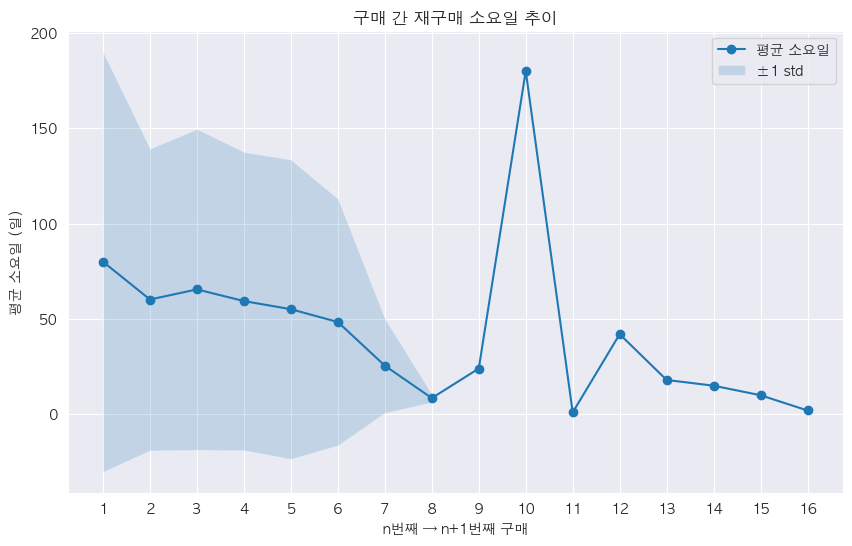

In [67]:
# 시각화
plt.figure(figsize=(10, 6))
plt.plot(interval_stats['order_rank'], interval_stats['mean'], marker='o', label='평균 소요일')
plt.fill_between(
    interval_stats['order_rank'],
    interval_stats['mean'] - interval_stats['std'],
    interval_stats['mean'] + interval_stats['std'],
    alpha=0.2, label='±1 std'
)
plt.title('구매 간 재구매 소요일 추이')
plt.xlabel('n번째 → n+1번째 구매')
plt.ylabel('평균 소요일 (일)')
plt.xticks(interval_stats['order_rank'])
plt.legend()
plt.grid(True)
plt.show()

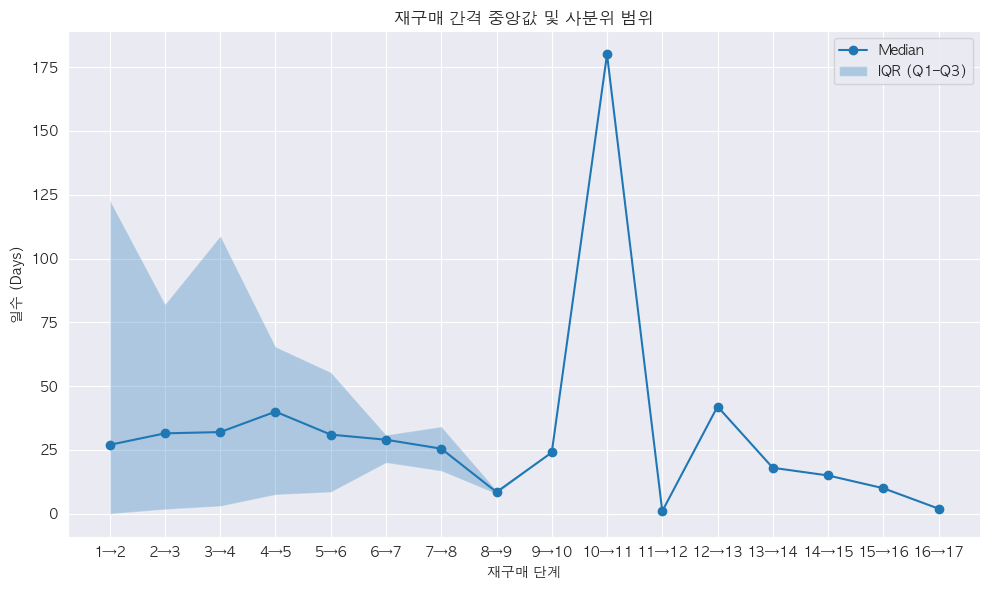

In [68]:
# 중앙값 기반

# 1. 구매 순서별 타임스탬프 피벗 테이블 만들기
pivot_df = filtered_customers.pivot_table(
    index='customer_unique_id',
    columns='order_rank',
    values='order_purchase_timestamp'
)

# 2. 재구매 간격 계산 (n번째 → n+1번째)
intervals = {}
for i in range(1, pivot_df.columns.max()):
    if i+1 in pivot_df.columns:
        day_diff = (pivot_df[i+1] - pivot_df[i]).dt.days
        intervals[f'{i}→{i+1}'] = day_diff

# 3. DataFrame으로 정리
interval_df = pd.DataFrame(intervals)

# 4. 중앙값, Q1, Q3 계산
interval_stats = pd.DataFrame({
    'median': interval_df.median(),
    'q1': interval_df.quantile(0.25),
    'q3': interval_df.quantile(0.75)
})

# 5. 시각화
plt.figure(figsize=(10, 6))
x = range(1, len(interval_stats) + 1)
labels = interval_stats.index

plt.plot(x, interval_stats['median'], marker='o', label='Median')
plt.fill_between(x, interval_stats['q1'], interval_stats['q3'], alpha=0.3, label='IQR (Q1–Q3)')
plt.xticks(x, labels)
plt.xlabel('재구매 단계')
plt.ylabel('일수 (Days)')
plt.title('재구매 간격 중앙값 및 사분위 범위')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [69]:
interval_stats

,median,q1,q3
1→2,27.0,0.00,123.00
2→3,31.5,1.75,82.25
3→4,32.0,3.00,109.00
4→5,40.0,7.50,65.50
5→6,31.0,8.50,55.50
6→7,29.0,20.00,31.00
7→8,25.5,16.75,34.25
8→9,8.5,7.75,9.25
9→10,24.0,24.00,24.00
10→11,180.0,180.00,180.00


### RFM 기반 이탈 여부 클래스 분류
- 이탈: 1
- 잔존: 0

In [70]:
filtered_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6342 entries, 0 to 99427
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       6342 non-null   object        
 1   customer_id                    6342 non-null   object        
 2   order_status                   6342 non-null   object        
 3   order_purchase_timestamp       6342 non-null   datetime64[ns]
 4   order_approved_at              6278 non-null   object        
 5   order_delivered_carrier_date   6180 non-null   object        
 6   order_delivered_customer_date  6099 non-null   object        
 7   order_estimated_delivery_date  6342 non-null   object        
 8   customer_unique_id             6342 non-null   object        
dtypes: datetime64[ns](1), object(8)
memory usage: 495.5+ KB


In [71]:
merged_df1 = filtered_orders.merge(
    order_payments_df[['order_id', 'payment_value']],
    on='order_id',
    how='left'
)

merged_df1

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,18.59
3,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,delivered,2018-06-07 19:03:12,2018-06-12 23:31:02,2018-06-11 14:54:00,2018-06-21 15:34:32,2018-07-04 00:00:00,ccafc1c3f270410521c3c6f3b249870f,146.45
4,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,delivered,2018-01-02 19:00:43,2018-01-02 19:09:04,2018-01-03 18:19:09,2018-01-20 01:38:59,2018-02-06 00:00:00,6e26bbeaa107ec34112c64e1ee31c0f5,1376.45
...,...,...,...,...,...,...,...,...,...,...
6718,58edf3f5f282ab91e0f6a6f2b85af02a,14945bc802d49b0f9f68f2ea8fd060c4,delivered,2018-05-07 09:01:58,2018-05-08 04:34:10,2018-05-10 12:35:00,2018-05-14 18:52:56,2018-05-30 00:00:00,62b8761192c86f4ead06f4a433096a2b,856.16
6719,bfecb4ee6ab98bff69307aab578db48a,e6f5f771cdbc5d09c994f16c9af6523d,delivered,2018-03-17 12:52:37,2018-03-17 13:10:35,2018-03-20 17:47:33,2018-03-27 19:16:57,2018-04-12 00:00:00,dca9a13536adcef18c6c5859487347b1,374.93
6720,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00,d05c44a138277ad325d915c6b7ccbcdf,107.13
6721,1b4a0e6b19d0034b531655b41ea89623,ce5efd1b1d8a2fa290a871edd5c26cd6,delivered,2017-10-02 08:45:35,2017-10-02 08:56:53,2017-10-03 20:26:19,2017-10-06 16:58:25,2017-10-24 00:00:00,39fff7cb5873a7116b02234bd1e6c6dc,49.75


In [72]:
merged_df2 = merged_df1.merge(
    unique_customer_df[['customer_unique_id', 'unique_order_count']],
    on='customer_unique_id',
    how='left'
)

merged_df2

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,payment_value,unique_order_count
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,18.12,2
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,2.00,2
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,18.59,2
3,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,delivered,2018-06-07 19:03:12,2018-06-12 23:31:02,2018-06-11 14:54:00,2018-06-21 15:34:32,2018-07-04 00:00:00,ccafc1c3f270410521c3c6f3b249870f,146.45,2
4,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,delivered,2018-01-02 19:00:43,2018-01-02 19:09:04,2018-01-03 18:19:09,2018-01-20 01:38:59,2018-02-06 00:00:00,6e26bbeaa107ec34112c64e1ee31c0f5,1376.45,2
...,...,...,...,...,...,...,...,...,...,...,...
6718,58edf3f5f282ab91e0f6a6f2b85af02a,14945bc802d49b0f9f68f2ea8fd060c4,delivered,2018-05-07 09:01:58,2018-05-08 04:34:10,2018-05-10 12:35:00,2018-05-14 18:52:56,2018-05-30 00:00:00,62b8761192c86f4ead06f4a433096a2b,856.16,2
6719,bfecb4ee6ab98bff69307aab578db48a,e6f5f771cdbc5d09c994f16c9af6523d,delivered,2018-03-17 12:52:37,2018-03-17 13:10:35,2018-03-20 17:47:33,2018-03-27 19:16:57,2018-04-12 00:00:00,dca9a13536adcef18c6c5859487347b1,374.93,2
6720,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00,d05c44a138277ad325d915c6b7ccbcdf,107.13,2
6721,1b4a0e6b19d0034b531655b41ea89623,ce5efd1b1d8a2fa290a871edd5c26cd6,delivered,2017-10-02 08:45:35,2017-10-02 08:56:53,2017-10-03 20:26:19,2017-10-06 16:58:25,2017-10-24 00:00:00,39fff7cb5873a7116b02234bd1e6c6dc,49.75,2


In [73]:
print(merged_df2['unique_order_count'].unique()) # [ 2  3  6  4 17  5  9  7]
print(merged_df2['customer_unique_id'].nunique()) # 2997

[ 2  3  6  4 17  5  9  7]
2997


In [74]:
rfm_df = merged_df2[['customer_unique_id', 'order_purchase_timestamp', 'order_id', 'payment_value']]
rfm_df.head()

,customer_unique_id,order_purchase_timestamp,order_id,payment_value
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,18.12
1,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,2.00
2,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,18.59
3,ccafc1c3f270410521c3c6f3b249870f,2018-06-07 19:03:12,dcb36b511fcac050b97cd5c05de84dc3,146.45
4,6e26bbeaa107ec34112c64e1ee31c0f5,2018-01-02 19:00:43,403b97836b0c04a622354cf531062e5f,1376.45


In [75]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6723 entries, 0 to 6722
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        6723 non-null   object        
 1   order_purchase_timestamp  6723 non-null   datetime64[ns]
 2   order_id                  6723 non-null   object        
 3   payment_value             6723 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 210.2+ KB


In [76]:
rfm_df = rfm_df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': 'max',
    'order_id': pd.Series.nunique,
    'payment_value': 'sum'
})
rfm_df = rfm_df.rename(columns={
    'order_purchase_timestamp': 'Recency', # 최근 구매 경과일
    'order_id': 'Frequency', # 구매 빈도
    'payment_value': 'Monetary' # 총 구매금액
})
rfm_df.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
00172711b30d52eea8b313a7f2cced02,2018-08-13 09:14:07,2,244.14
004288347e5e88a27ded2bb23747066c,2018-01-14 07:36:54,2,354.37
004b45ec5c64187465168251cd1c9c2f,2018-05-26 19:42:48,2,147.72
0058f300f57d7b93c477a131a59b36c3,2018-03-22 18:09:41,2,175.58
00a39521eb40f7012db50455bf083460,2018-06-03 10:12:57,2,123.25


In [77]:
print(rfm_df['Frequency'].unique())
rfm_df.shape

[ 2  3  4  6  7  5  9 17]


(2997, 3)

In [78]:
# Recency 날짜형을 숫자형으로 변환
max_date = rfm_df['Recency'].max()
rfm_df['Recency'] = max_date - rfm_df['Recency'] # timedelta 자료형
rfm_df['Recency']

customer_unique_id
00172711b30d52eea8b313a7f2cced02    64 days 11:01:55
004288347e5e88a27ded2bb23747066c   275 days 12:39:08
004b45ec5c64187465168251cd1c9c2f   143 days 00:33:14
0058f300f57d7b93c477a131a59b36c3   208 days 02:06:21
00a39521eb40f7012db50455bf083460   135 days 10:03:05
                                          ...       
ff36be26206fffe1eb37afd54c70e18b    54 days 07:37:54
ff44401d0d8f5b9c54a47374eb48c1b8   514 days 22:55:08
ff8892f7c26aa0446da53d01b18df463   323 days 20:50:19
ff922bdd6bafcdf99cb90d7f39cea5b3   397 days 05:51:58
ffe254cc039740e17dd15a5305035928   562 days 03:42:32
Name: Recency, Length: 2997, dtype: timedelta64[ns]

In [79]:
rfm_df['Recency'] = rfm_df['Recency'].apply(lambda x: x.days + 1)
rfm_df.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
00172711b30d52eea8b313a7f2cced02,65,2,244.14
004288347e5e88a27ded2bb23747066c,276,2,354.37
004b45ec5c64187465168251cd1c9c2f,144,2,147.72
0058f300f57d7b93c477a131a59b36c3,209,2,175.58
00a39521eb40f7012db50455bf083460,136,2,123.25


In [80]:
# RFM 값 분포
rfm_df.describe()

,Recency,Frequency,Monetary
count,2997.000000,2997.000000,2997.000000
mean,268.364698,2.116116,314.989226
std,145.358438,0.516610,369.591581
min,1.000000,2.000000,34.970000
25%,152.000000,2.000000,146.000000
50%,248.000000,2.000000,225.840000
75%,366.000000,2.000000,362.780000
max,740.000000,17.000000,9553.020000


In [81]:
rfm_df['Frequency'].value_counts()

Frequency
2     2745
3      203
4       30
5        8
6        6
7        3
9        1
17       1
Name: count, dtype: int64

In [82]:
# 구간 설정 및 범주 이름 지정
bins = [0, 2, 5, float('inf')]  # 0~2: low, 3~5: mid, 6~: high
labels = ['low', 'mid', 'high']

# 구간화
rfm_df['Frequency_level'] = pd.cut(rfm_df['Frequency'], bins=bins, labels=labels)

rfm_df

,Recency,Frequency,Monetary,Frequency_level
customer_unique_id,,,,
00172711b30d52eea8b313a7f2cced02,65,2,244.14,low
004288347e5e88a27ded2bb23747066c,276,2,354.37,low
004b45ec5c64187465168251cd1c9c2f,144,2,147.72,low
0058f300f57d7b93c477a131a59b36c3,209,2,175.58,low
00a39521eb40f7012db50455bf083460,136,2,123.25,low
...,...,...,...,...
ff36be26206fffe1eb37afd54c70e18b,55,3,278.28,mid
ff44401d0d8f5b9c54a47374eb48c1b8,515,2,68.00,low
ff8892f7c26aa0446da53d01b18df463,324,2,330.14,low


In [83]:
# 매핑 딕셔너리 정의
f_score_map = {
    'low': 1,
    'mid': 3,
    'high': 5
}

# Categorical 컬럼을 문자열로 변환 후 매핑
rfm_df['F_score'] = rfm_df['Frequency_level'].astype(str).map(f_score_map).fillna(2).astype(int)

In [84]:
# 분위수 구간 계산 (NaN 발생 대비 + 분위수 구간 부족 대비)
for col in ['Recency', 'Monetary']:
    try:
        rfm_df[col[0] + '_quantile'] = pd.qcut(
            rfm_df[col],
            5,
            labels=False,
            duplicates='drop'
        )
    except ValueError:
        # 전부 동일하거나 분위수 계산 불가한 경우 → 값 전체를 중간값으로 처리
        rfm_df[col[0] + '_quantile'] = 2

# NaN이 생긴 경우 기본값 2로 대체
rfm_df[['R_quantile', 'M_quantile']] = rfm_df[['R_quantile', 'M_quantile']].fillna(2)

# RFM 점수 계산
rfm_df['R_score'] = (5 - rfm_df['R_quantile']).astype(int)  # Recency는 낮을수록 높게
rfm_df['M_score'] = (1 + rfm_df['M_quantile']).astype(int)

# 최종 RFM Score 조합
rfm_df['RFM_score'] = (
    rfm_df['R_score'].astype(str) +
    rfm_df['F_score'].astype(str) +
    rfm_df['M_score'].astype(str)
)

# 결과 출력
print(rfm_df[['Recency', 'Frequency', 'Monetary', 'R_score', 'F_score', 'M_score', 'RFM_score']])

                                  Recency  Frequency  Monetary  R_score  \
customer_unique_id                                                        
00172711b30d52eea8b313a7f2cced02       65          2    244.14        5   
004288347e5e88a27ded2bb23747066c      276          2    354.37        3   
004b45ec5c64187465168251cd1c9c2f      144          2    147.72        4   
0058f300f57d7b93c477a131a59b36c3      209          2    175.58        4   
00a39521eb40f7012db50455bf083460      136          2    123.25        4   
...                                   ...        ...       ...      ...   
ff36be26206fffe1eb37afd54c70e18b       55          3    278.28        5   
ff44401d0d8f5b9c54a47374eb48c1b8      515          2     68.00        1   
ff8892f7c26aa0446da53d01b18df463      324          2    330.14        2   
ff922bdd6bafcdf99cb90d7f39cea5b3      398          3    139.60        2   
ffe254cc039740e17dd15a5305035928      563          2     80.12        1   

                        

In [85]:
print(rfm_df['R_score'].value_counts())
print(rfm_df['F_score'].value_counts())
print(rfm_df['M_score'].value_counts())

R_score
4    606
2    603
5    602
1    596
3    590
Name: count, dtype: int64
F_score
1    2745
3     241
5      11
Name: count, dtype: int64
M_score
1    600
5    600
3    599
4    599
2    599
Name: count, dtype: int64


In [86]:
def classify_churn(row):
    if row['R_score'] <= 2 and row['F_score'] <= 2:
        return 1
    else:
        return 0

# 이탈 여부 태깅
rfm_df['churn'] = rfm_df.apply(classify_churn, axis=1)

In [87]:
# R_score가 2 이하인 고객 필터링
low_r_score_df = rfm_df[rfm_df['R_score'] <= 2]

# 해당 고객의 Recency 값만 확인
print(low_r_score_df['Recency'].describe())

count    1199.000000
mean      417.438699
std        91.372631
min       289.000000
25%       334.000000
50%       400.000000
75%       484.000000
max       740.000000
Name: Recency, dtype: float64


In [88]:
# M_score 필터링
churn_m_score_df = rfm_df[rfm_df['churn'] == 1]
cust_m_score_df = rfm_df[rfm_df['churn'] == 0]

# 해당 고객의 Monentary 값만 확인
print('이탈 Monentary: ', churn_m_score_df['Monetary'].describe(), '\n')
print('잔존 Monentary: ', cust_m_score_df['Monetary'].describe())

이탈 Monentary:  count    1117.000000
mean      295.011406
std       376.850740
min        36.740000
25%       133.310000
50%       206.730000
75%       333.170000
max      7571.630000
Name: Monetary, dtype: float64 

잔존 Monentary:  count    1880.000000
mean      326.859027
std       364.793306
min        34.970000
25%       153.427500
50%       237.895000
75%       376.602500
max      9553.020000
Name: Monetary, dtype: float64


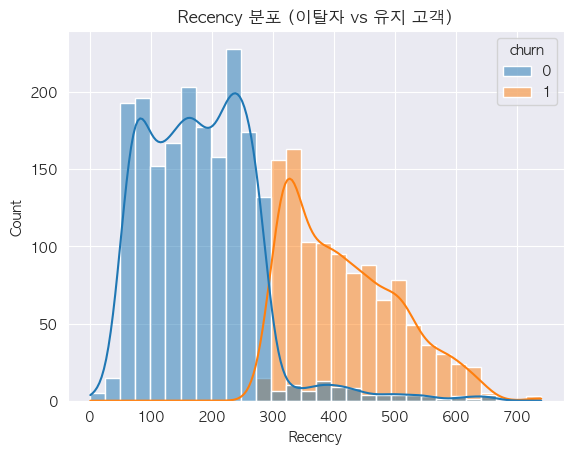

In [89]:
sns.histplot(data=rfm_df, x='Recency', hue='churn', kde=True, bins=30)
plt.title('Recency 분포 (이탈자 vs 유지 고객)')
plt.show()

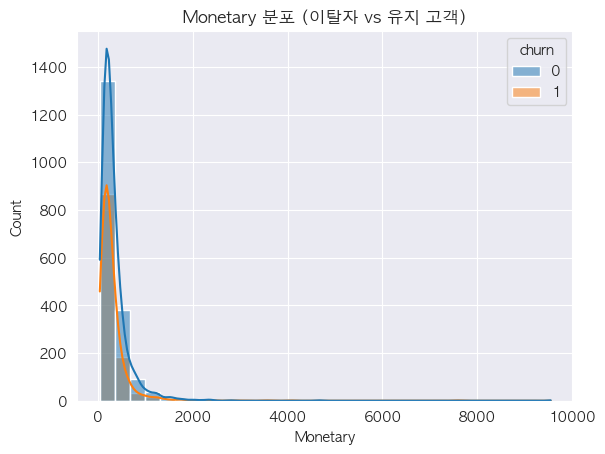

In [90]:
sns.histplot(data=rfm_df, x='Monetary', hue='churn', kde=True, bins=30)
plt.title('Monetary 분포 (이탈자 vs 유지 고객)')
plt.show()

In [91]:
rfm_df['churn'].value_counts()

churn
0    1880
1    1117
Name: count, dtype: int64

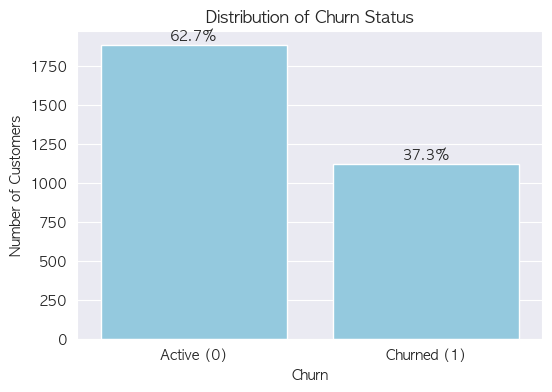

In [92]:
churn_counts = rfm_df['churn'].value_counts().sort_index()
total = churn_counts.sum()

plt.figure(figsize=(6,4))
ax = sns.barplot(x=churn_counts.index, y=churn_counts.values, color='skyblue')

plt.xticks([0,1], ['Active (0)', 'Churned (1)'])
plt.xlabel('Churn')
plt.ylabel('Number of Customers')
plt.title('Distribution of Churn Status')

# 막대 위에 비율 표시
for i, count in enumerate(churn_counts.values):
    percentage = count / total * 100
    ax.text(i, count + total*0.01, f'{percentage:.1f}%', ha='center')

plt.show()

### 모델 학습용 Feature 구성

In [93]:
# One-hot 인코딩
rfm_df_encoded = pd.get_dummies(rfm_df, columns=['Frequency_level'], prefix='freq', drop_first=True)

rfm_df_encoded.head()
rfm_df_encoded = rfm_df_encoded.astype(int)

rfm_df_encoded.head()

,Recency,Frequency,Monetary,F_score,R_quantile,M_quantile,R_score,M_score,RFM_score,churn,freq_mid,freq_high
customer_unique_id,,,,,,,,,,,,
00172711b30d52eea8b313a7f2cced02,65,2,244,1,0,2,5,3,513,0,0,0
004288347e5e88a27ded2bb23747066c,276,2,354,1,2,3,3,4,314,0,0,0
004b45ec5c64187465168251cd1c9c2f,144,2,147,1,1,1,4,2,412,0,0,0
0058f300f57d7b93c477a131a59b36c3,209,2,175,1,1,1,4,2,412,0,0,0
00a39521eb40f7012db50455bf083460,136,2,123,1,1,0,4,1,411,0,0,0


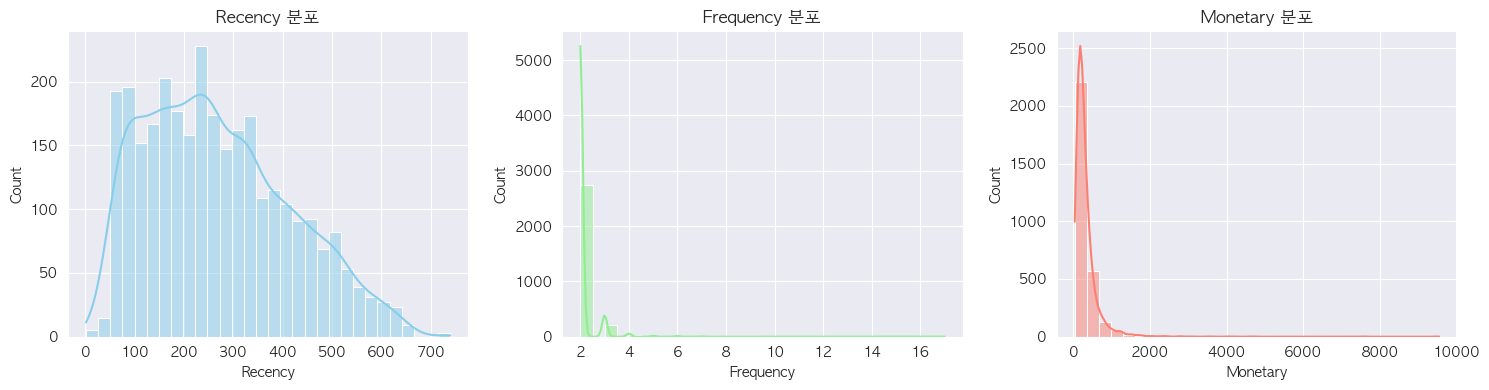

In [94]:
# 시각화 설정
plt.figure(figsize=(15, 4))

# Recency
plt.subplot(1, 3, 1)
sns.histplot(rfm_df_encoded['Recency'], kde=True, bins=30, color='skyblue')
plt.title('Recency 분포')

# Frequency
plt.subplot(1, 3, 2)
sns.histplot(rfm_df_encoded['Frequency'], kde=True, bins=30, color='lightgreen')
plt.title('Frequency 분포')

# Monetary
plt.subplot(1, 3, 3)
sns.histplot(rfm_df_encoded['Monetary'], kde=True, bins=30, color='salmon')
plt.title('Monetary 분포')

plt.tight_layout()
plt.show()


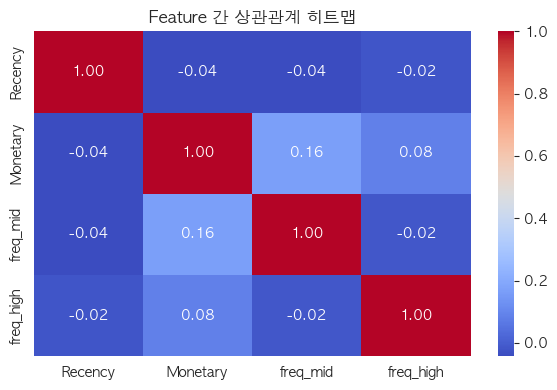

In [95]:
# Feature 구성
features = ['Recency', 'Monetary', 'freq_mid', 'freq_high']

# 상관계수 행렬 계산
correlation_matrix = rfm_df_encoded[features].corr(method='pearson')

# 시각화 (히트맵)
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature 간 상관관계 히트맵')
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 25 candidates, totalling 125 fits
✅ Best Parameters: {'svm__C': 100, 'svm__gamma': 1}
🏅 Best Cross-Validated ROC AUC Score: 1.0000
📊 [Classification Report]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       376
           1       1.00      0.99      0.99       224

    accuracy                           0.99       600
   macro avg       1.00      0.99      0.99       600
weighted avg       1.00      0.99      0.99       600

📉 [Confusion Matrix]


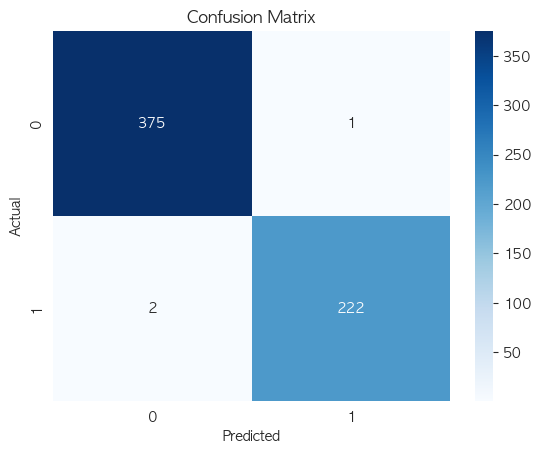

📈 ROC AUC Score (Test Set): 1.0000


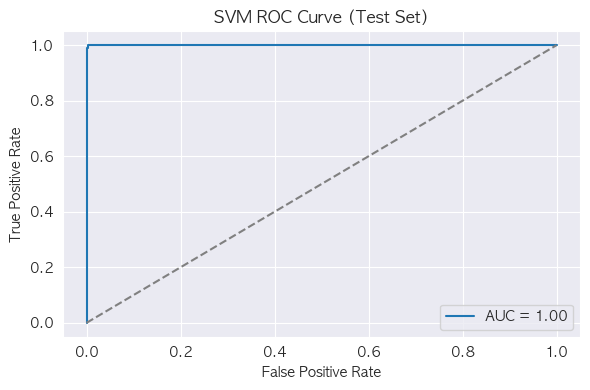

In [96]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Feature 및 Target 정의
X = rfm_df_encoded[features]
y = rfm_df_encoded['churn']

# 2. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. 파이프라인 정의 (StandardScaler + SVC)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42))
])

# 4. 하이퍼파라미터 탐색 범위
param_grid = {
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 10]
}

# 5. 교차검증 및 GridSearchCV 정의
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='roc_auc',  # or 'f1' based on your goal
    n_jobs=-1,
    verbose=1
)

# 6. GridSearchCV로 모델 학습
grid_search.fit(X_train, y_train)

# 7. 최적 모델 확인
print("✅ Best Parameters:", grid_search.best_params_)
print(f"🏅 Best Cross-Validated ROC AUC Score: {grid_search.best_score_:.4f}")

# 8. 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# 9. 성능 평가
print("📊 [Classification Report]")
print(classification_report(y_test, y_pred))

print("📉 [Confusion Matrix]")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print(f"📈 ROC AUC Score (Test Set): {roc_auc:.4f}")

# 10. ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()

In [97]:
# 과적합 확인
y_train_pred = best_model.predict(X_train)

from sklearn.metrics import f1_score

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"Train F1-score: {train_f1:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

Train F1-score: 0.9994
Test F1-score: 0.9933


In [98]:
# 1회 구매자 포함 모델 학습


# 초기 EDA

In [99]:
# 고객별 주문 횟수
purchase_frequency = filtered_customers.groupby('customer_unique_id').size().reset_index(name='purchase_count')

# 구매 빈도 내림차순 정렬
purchase_frequency = purchase_frequency.sort_values(by='purchase_count', ascending=False)

# 결과 확인
purchase_frequency['customer_unique_id'].nunique()
purchase_frequency.head()

,customer_unique_id,purchase_count
1661,8d50f5eadf50201ccdcedfb9e2ac8455,17
719,3e43e6105506432c953e165fb2acf44c,9
332,1b6c7548a2a1f9037c1fd3ddfed95f33,7
1169,6469f99c1f9dfae7733b25662e7f1782,7
2385,ca77025e7201e3b30c44b472ff346268,7


In [100]:
purchase_frequency['purchase_count'].describe()

count    2997.000000
mean        2.116116
std         0.516610
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        17.000000
Name: purchase_count, dtype: float64

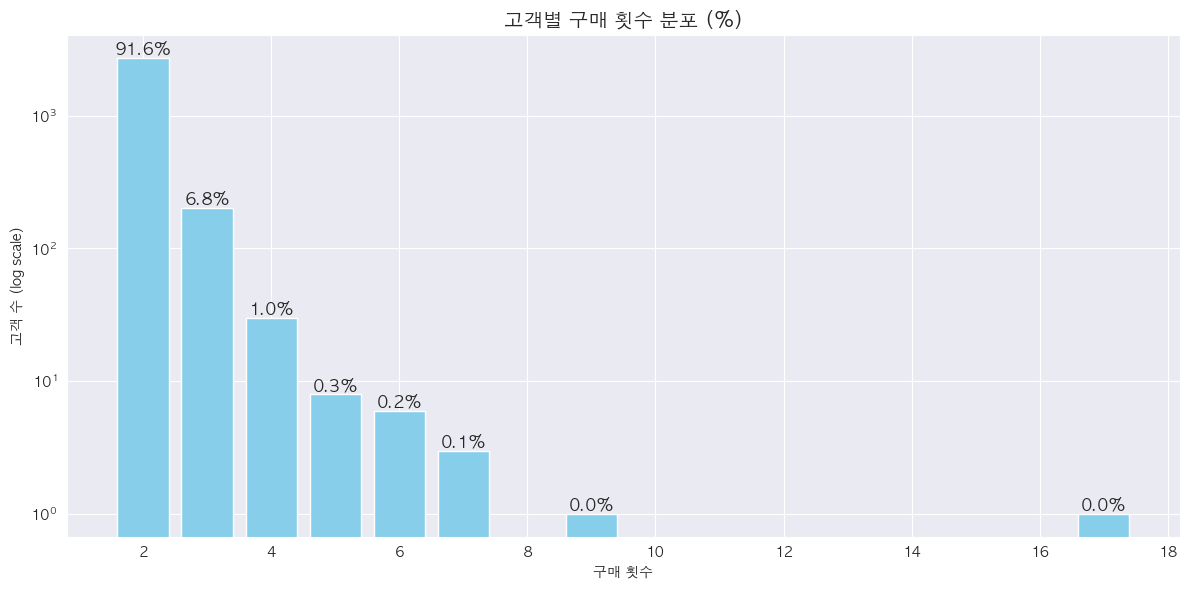

In [101]:
# 구매 횟수 빈도
counts = purchase_frequency['purchase_count'].value_counts().sort_index()
total = counts.sum()
percentages = counts / total * 100

# 시각화
plt.figure(figsize=(12, 6))
bars = plt.bar(counts.index, counts.values, color='skyblue')

plt.yscale('log')  # 로그 스케일
plt.title('고객별 구매 횟수 분포 (%)', fontsize=14)
plt.xlabel('구매 횟수')
plt.ylabel('고객 수 (log scale)')
plt.grid(True)

# 막대 위에 비율 (%) 표시
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    if height > 0:  # 0인 경우 표시 생략
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{pct:.1f}%',
                 ha='center', va='bottom', fontsize=12, rotation=0)

plt.tight_layout()
plt.show()


In [102]:
# 이상치 추출
Q1 = purchase_frequency['purchase_count'].quantile(0.25)
Q3 = purchase_frequency['purchase_count'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = purchase_frequency[
    (purchase_frequency['purchase_count'] < lower_bound) |
    (purchase_frequency['purchase_count'] > upper_bound)
]

outlier_ratio = len(outliers) / filtered_customers['customer_unique_id'].nunique() * 100
print("이상치 수:", len(outliers))
print(f"이상치 비중: {outlier_ratio:.2f}%")
display(outliers.sort_values(by='purchase_count', ascending=False))
print("upper bound:", upper_bound)

이상치 수: 252
이상치 비중: 8.41%


,customer_unique_id,purchase_count
1661,8d50f5eadf50201ccdcedfb9e2ac8455,17
719,3e43e6105506432c953e165fb2acf44c,9
332,1b6c7548a2a1f9037c1fd3ddfed95f33,7
1169,6469f99c1f9dfae7733b25662e7f1782,7
2385,ca77025e7201e3b30c44b472ff346268,7
...,...,...
1878,9d31457a03125fc870787a251760315a,3
1982,a72a2d4e19868dba726c0e6f49198c7e,3
2624,df946ef265626b1e0a425292815ddead,3
1904,a029899dd8534557a81c369475ff80c8,3


upper bound: 2.0


In [103]:
# 4회 이상 구매 고객 비율:  약 1.6%
filtered_freq = purchase_frequency[purchase_frequency['purchase_count'] > 3]
filtered_freq['customer_unique_id'].nunique() / purchase_frequency['customer_unique_id'].nunique() * 100

filtered_freq

,customer_unique_id,purchase_count
1661,8d50f5eadf50201ccdcedfb9e2ac8455,17
719,3e43e6105506432c953e165fb2acf44c,9
332,1b6c7548a2a1f9037c1fd3ddfed95f33,7
1169,6469f99c1f9dfae7733b25662e7f1782,7
2385,ca77025e7201e3b30c44b472ff346268,7
2592,dc813062e0fc23409cd255f7f53c7074,6
2845,f0e310a6839dce9de1638e0fe5ab282a,6
2612,de34b16117594161a6a89c50b289d35a,6
228,12f5d6e1cbf93dafd9dcc19095df0b3d,6
824,47c1a3033b8b77b3ab6e109eb4d5fdf3,6


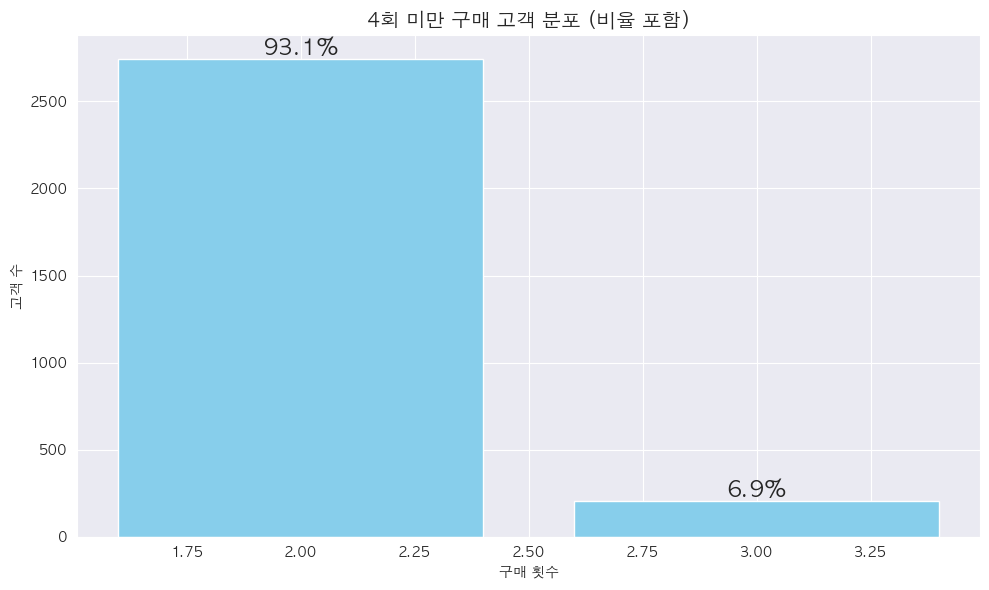

In [104]:
# 이상치 제거 (4회 이상)
import matplotlib.pyplot as plt

# ▶ 4회 미만 구매 고객만 추출
filtered_freq = purchase_frequency[purchase_frequency['purchase_count'] < 4]

# ▶ 구매 횟수별 고객 수와 비율 계산
counts = filtered_freq['purchase_count'].value_counts().sort_index()
total = counts.sum()
percentages = counts / total * 100

# ▶ 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(counts.index, counts.values, color='skyblue')

plt.title('4회 미만 구매 고객 분포 (비율 포함)', fontsize=14)
plt.xlabel('구매 횟수')
plt.ylabel('고객 수')
plt.grid(True, axis='y')

# ▶ 막대 위에 비율 (%) 표시
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # 가운데 정렬
        height,                            # 막대 위
        f'{pct:.1f}%',                     # 표시할 비율
        ha='center',
        va='bottom',
        fontsize=16
    )

plt.tight_layout()
plt.show()

In [105]:
# 1~3회 구매 고객만 필터링
filtered_customers = filtered_customers[filtered_customers['customer_unique_id'].isin(filtered_freq['customer_unique_id'])]

# 인덱스 정리
filtered_customers = filtered_customers.reset_index(drop=True)

# 결과 확인
filtered_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,order_rank
0,bb874c45df1a3c97842d52f31efee99a,1afe8a9c67eec3516c09a8bdcc539090,delivered,2018-07-28 00:23:49,2018-07-28 00:35:19,2018-07-31 15:57:00,2018-08-07 19:28:41,2018-08-22 00:00:00,00172711b30d52eea8b313a7f2cced02,1
1,c306eca42d32507b970739b5b6a5a33a,24b0e2bd287e47d54d193e7bbb51103f,canceled,2018-08-13 09:14:07,NaN,NaN,NaN,2018-09-05 00:00:00,00172711b30d52eea8b313a7f2cced02,2
2,a61d617fbe5bd006e40d3a0988fc844b,1b4a75b3478138e99902678254b260f4,delivered,2017-07-27 14:13:03,2017-07-27 14:25:14,2017-07-28 17:45:36,2017-08-04 16:26:54,2017-08-18 00:00:00,004288347e5e88a27ded2bb23747066c,1
3,08204559bebd39e09ee52dcb56d8faa2,f6efe5d5c7b85e12355f9d5c3db46da2,delivered,2018-01-14 07:36:54,2018-01-14 07:49:28,2018-01-16 16:39:34,2018-01-19 22:14:14,2018-02-09 00:00:00,004288347e5e88a27ded2bb23747066c,2
4,90ae229a4addcfead792e2564554f09c,49cf243e0d353cd418ca77868e24a670,shipped,2017-09-01 12:11:23,2017-09-05 04:30:20,2017-09-08 19:42:16,NaN,2017-10-06 00:00:00,004b45ec5c64187465168251cd1c9c2f,1


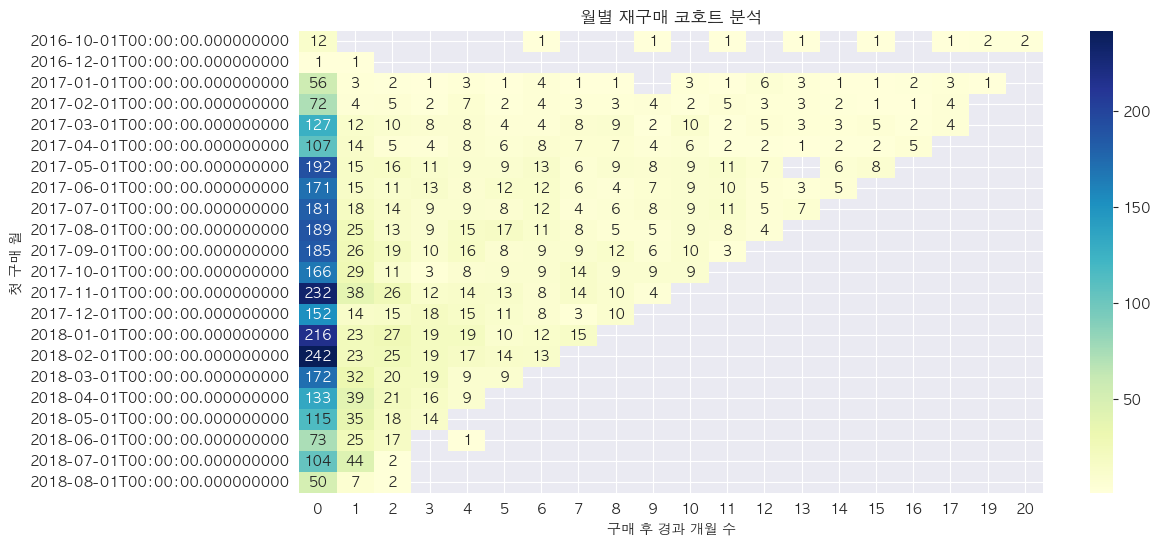

In [106]:
# 재구매 월별 코호트
filtered_customers = filtered_customers.copy()

filtered_customers['order_month'] = filtered_customers['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()

first_order = filtered_customers.groupby('customer_unique_id')['order_month'].min().reset_index()
first_order.columns = ['customer_unique_id', 'cohort_month']

orders_cohort = pd.merge(filtered_customers, first_order, on='customer_unique_id')

def get_month_diff(df):
    return (df['order_month'].dt.year - df['cohort_month'].dt.year) * 12 + (df['order_month'].dt.month - df['cohort_month'].dt.month)

orders_cohort['cohort_index'] = get_month_diff(orders_cohort)

cohort_counts = orders_cohort.groupby(['cohort_month', 'cohort_index'])['customer_unique_id'].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index='cohort_month', columns='cohort_index', values='customer_unique_id')

plt.figure(figsize=(12, 6))
sns.heatmap(cohort_pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('월별 재구매 코호트 분석')
plt.xlabel('구매 후 경과 개월 수')
plt.ylabel('첫 구매 월')
plt.show()

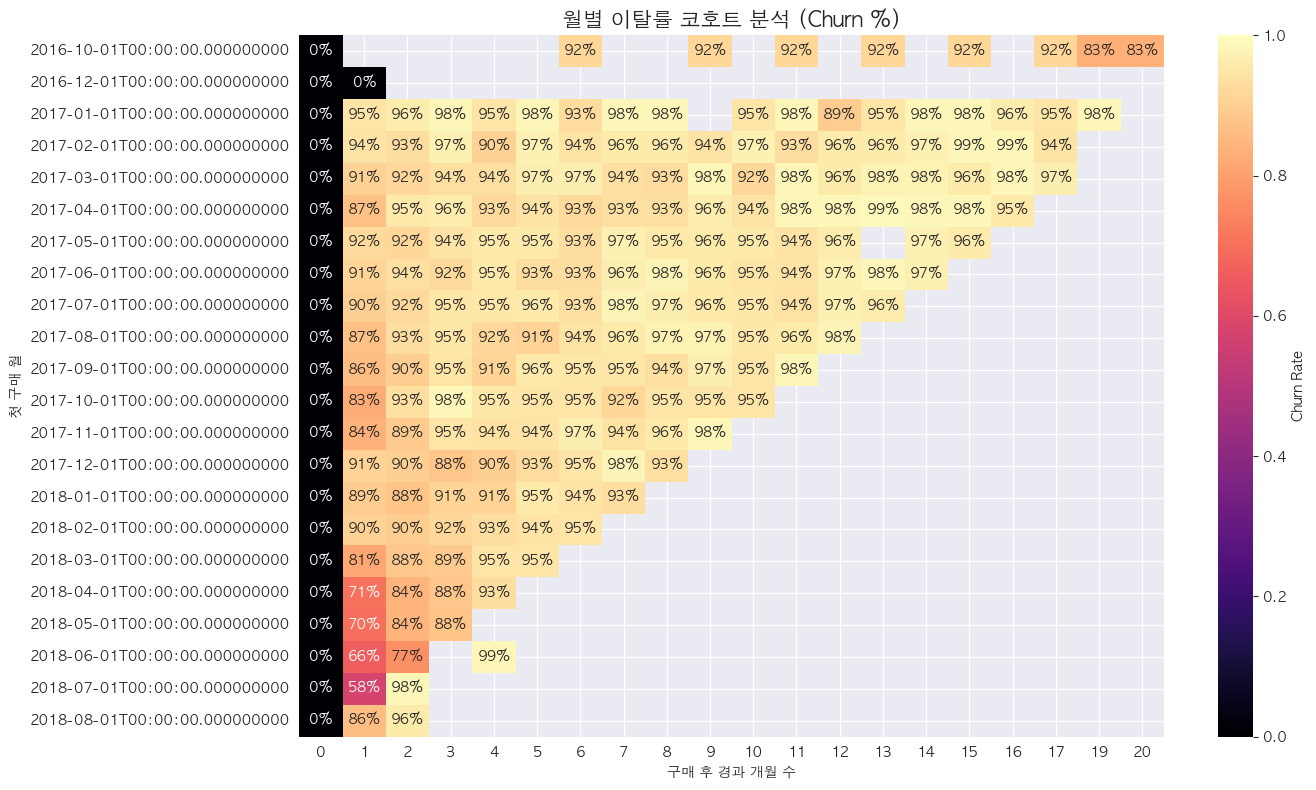

In [107]:
# 이탈률 월별 코호트

# 월별 전처리
filtered_customers['order_month'] = filtered_customers['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()

# 고객별 첫 주문 월
first_order = filtered_customers.groupby('customer_unique_id')['order_month'].min().reset_index()
first_order.columns = ['customer_unique_id', 'cohort_month']

# 병합 및 코호트 인덱스 계산
orders_cohort = pd.merge(filtered_customers, first_order, on='customer_unique_id')
orders_cohort['cohort_index'] = (
    (orders_cohort['order_month'].dt.year - orders_cohort['cohort_month'].dt.year) * 12 +
    (orders_cohort['order_month'].dt.month - orders_cohort['cohort_month'].dt.month)
)

# 월별 고유 고객 수
cohort_counts = orders_cohort.groupby(['cohort_month', 'cohort_index'])['customer_unique_id'].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index='cohort_month', columns='cohort_index', values='customer_unique_id')

# ▶ 유지율 계산
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

# ▶ 이탈률 계산 (1 - 유지율)
churn_rate = 1 - retention

# ▶ 시각화
plt.figure(figsize=(14, 8))
sns.heatmap(
    churn_rate,
    annot=True,
    fmt=".0%",
    cmap='magma',  # 이탈률에 적합한 강한 대비 색상
    vmin=0.0,
    vmax=1.0,
    cbar_kws={'label': 'Churn Rate'}
)

plt.title('월별 이탈률 코호트 분석 (Churn %)', fontsize=15)
plt.xlabel('구매 후 경과 개월 수')
plt.ylabel('첫 구매 월')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [108]:
# 년도별 첫 구매 고객 이탈률 분석

# 1) 고객별 첫 구매일 추출
first_purchase = filtered_customers.groupby('customer_unique_id')['order_purchase_timestamp'].min().reset_index()
first_purchase.columns = ['customer_unique_id', 'first_purchase_date']

# 2) 병합
orders = filtered_customers.merge(first_purchase, on='customer_unique_id', how='left')

# 3) 주 단위 코호트 생성 함수
def get_week_period(date):
    year = date.isocalendar().year
    week = date.isocalendar().week
    return f'{year}-W{week:02d}'

# 4) 코호트 컬럼 생성
orders['first_purchase_week'] = orders['first_purchase_date'].apply(get_week_period)
orders['order_week'] = orders['order_purchase_timestamp'].apply(get_week_period)

# 5) 주차 차이 계산 함수
def week_diff(row):
    y1, w1 = row['first_purchase_week'].split('-W')
    y2, w2 = row['order_week'].split('-W')
    diff_year = int(y2) - int(y1)
    diff_week = int(w2) - int(w1)
    return diff_year * 52 + diff_week

orders['weeks_since_first'] = orders.apply(week_diff, axis=1)

# 6) 2016~2018년 첫 구매 고객만 필터링
orders['first_purchase_year'] = orders['first_purchase_date'].dt.year
orders = orders[orders['first_purchase_year'].isin([2016, 2017, 2018])]

# 7) 코호트 사이즈 계산
cohort_sizes = first_purchase[first_purchase['first_purchase_date'].dt.year.isin([2016, 2017, 2018])].copy()
cohort_sizes['first_purchase_week'] = cohort_sizes['first_purchase_date'].apply(get_week_period)
cohort_sizes = cohort_sizes.groupby('first_purchase_week')['customer_unique_id'].nunique().reset_index()
cohort_sizes.columns = ['cohort_week', 'cohort_size']

# 8) 주차별 재구매 고객 수 집계
repeat_purchases = orders.groupby(['first_purchase_week', 'weeks_since_first'])['customer_unique_id'].nunique().reset_index()
repeat_purchases.columns = ['cohort_week', 'weeks_since_first', 'active_customers']

# 9) 병합 및 이탈률 계산
cohort_data = repeat_purchases.merge(cohort_sizes, on='cohort_week')
cohort_data['retention_rate'] = cohort_data['active_customers'] / cohort_data['cohort_size']
cohort_data['churn_rate'] = 1 - cohort_data['retention_rate']

# 10) 확인
print(cohort_data.head())

  cohort_week  weeks_since_first  active_customers  cohort_size  \
0    2016-W40                  0                11           11   
1    2016-W40                 27                 1           11   
2    2016-W40                 42                 1           11   
3    2016-W40                 51                 1           11   
4    2016-W40                 57                 1           11   

   retention_rate  churn_rate  
0        1.000000    0.000000  
1        0.090909    0.909091  
2        0.090909    0.909091  
3        0.090909    0.909091  
4        0.090909    0.909091  


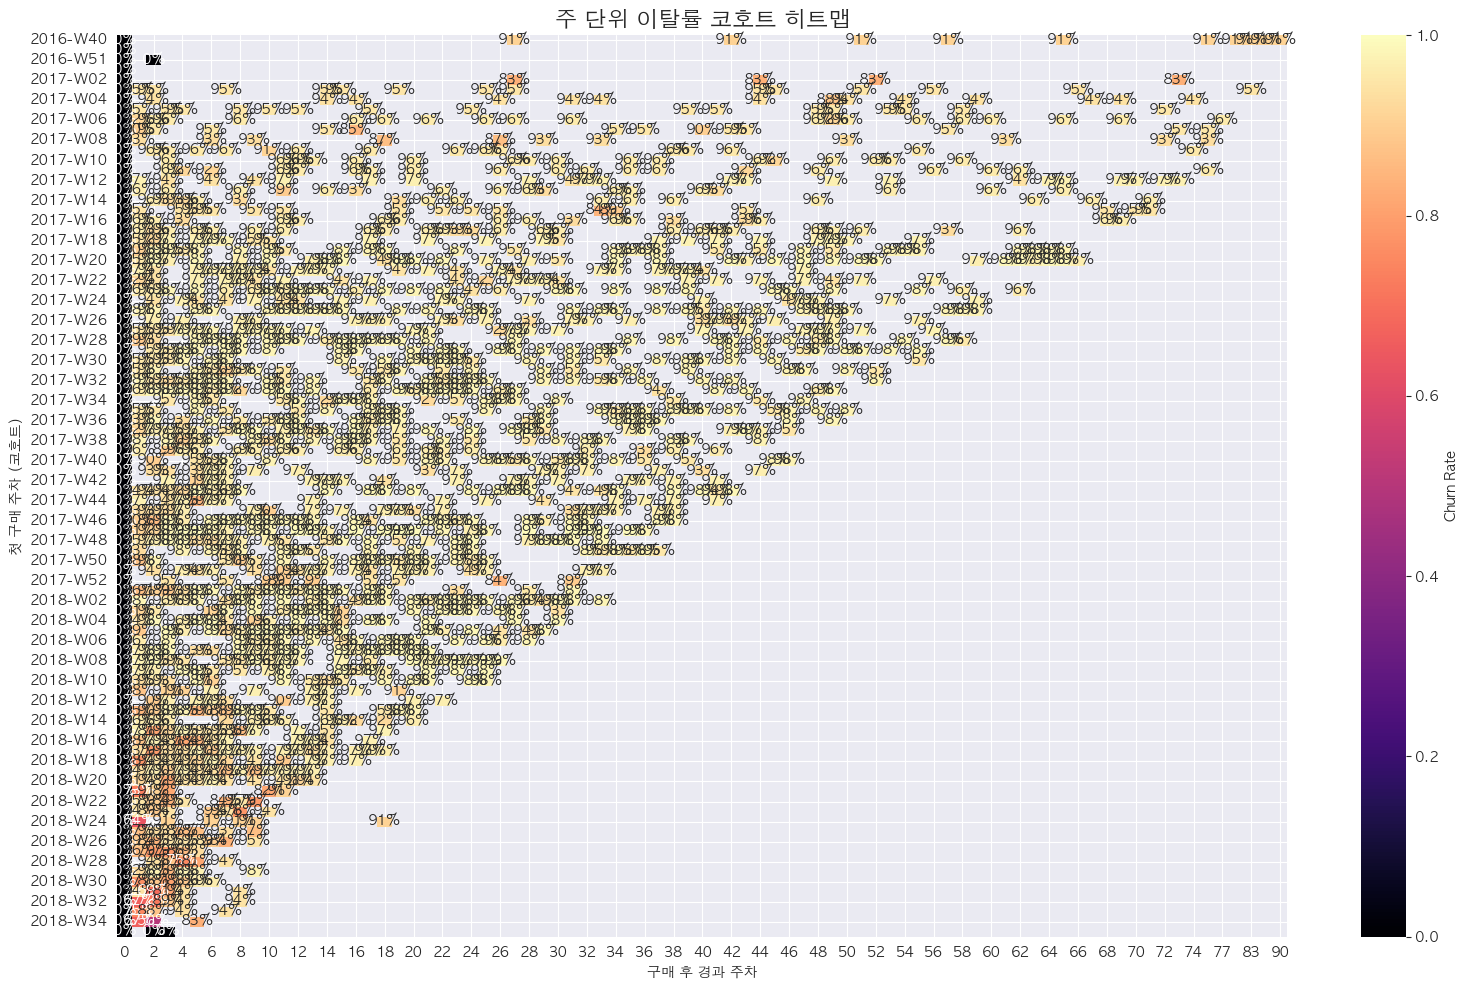

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1) Pivot 테이블로 변환 (행: 코호트 시작 주, 열: 경과 주차)
churn_pivot = cohort_data.pivot(index='cohort_week', columns='weeks_since_first', values='churn_rate')

# 2) 히트맵 시각화
plt.figure(figsize=(16, 10))
sns.heatmap(
    churn_pivot,
    annot=True,         # 각 셀에 수치 표시
    fmt=".0%",          # 백분율 형식
    cmap='magma',       # 대비 강한 컬러맵
    vmin=0.0,
    vmax=1.0,
    cbar_kws={'label': 'Churn Rate'}
)

plt.title('주 단위 이탈률 코호트 히트맵', fontsize=16)
plt.xlabel('구매 후 경과 주차')
plt.ylabel('첫 구매 주차 (코호트)')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

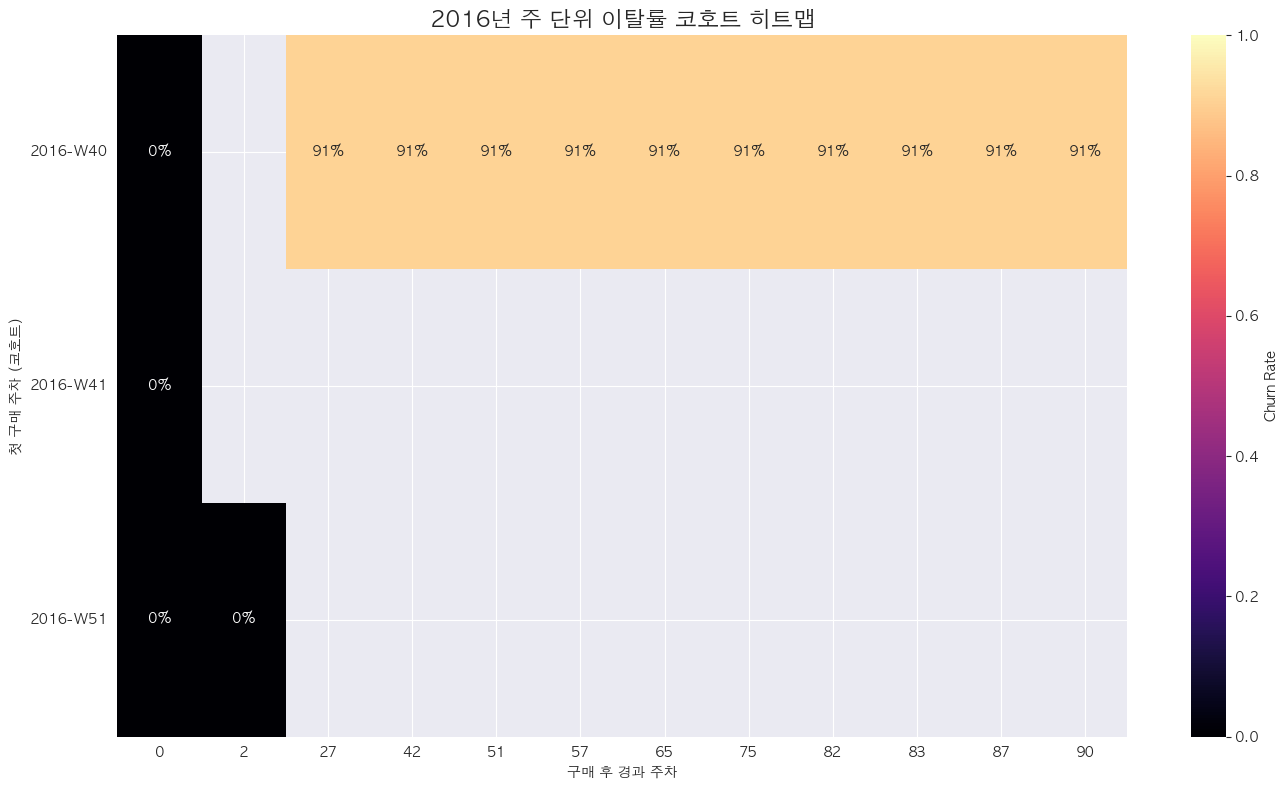

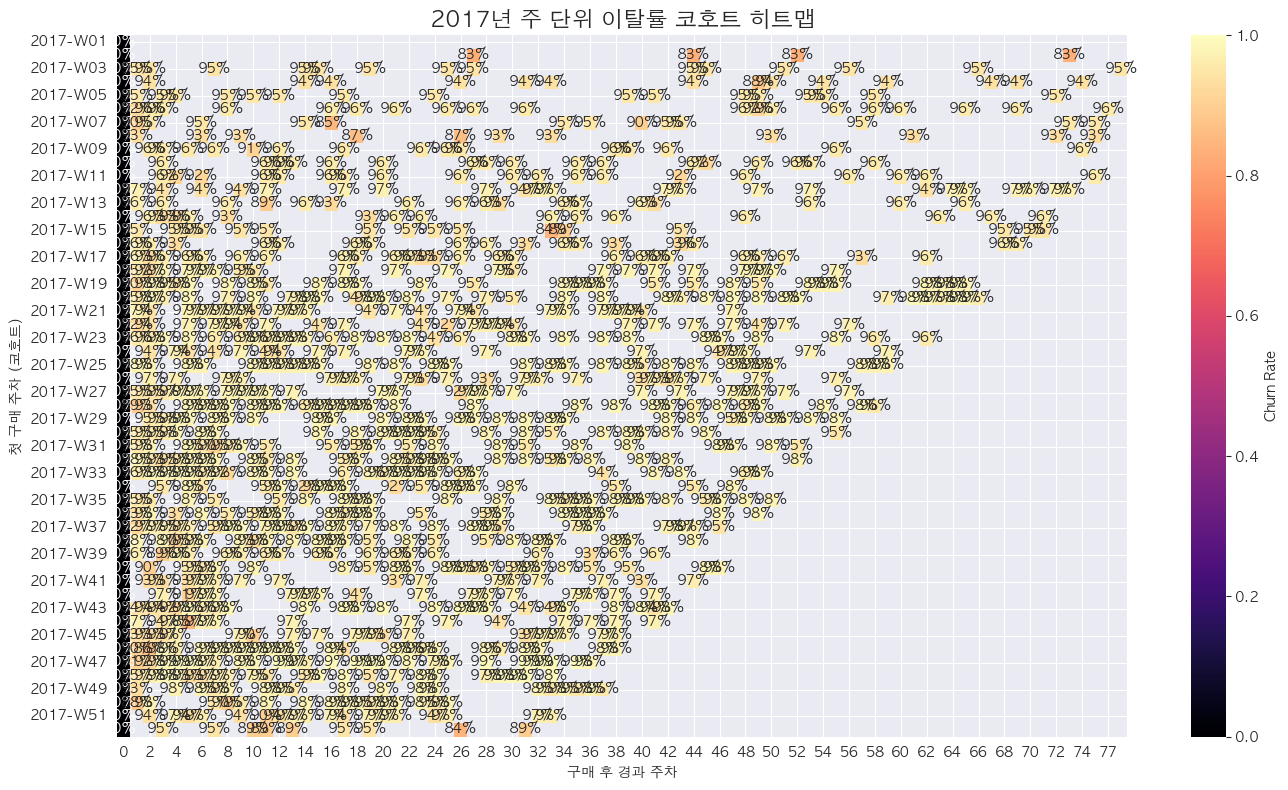

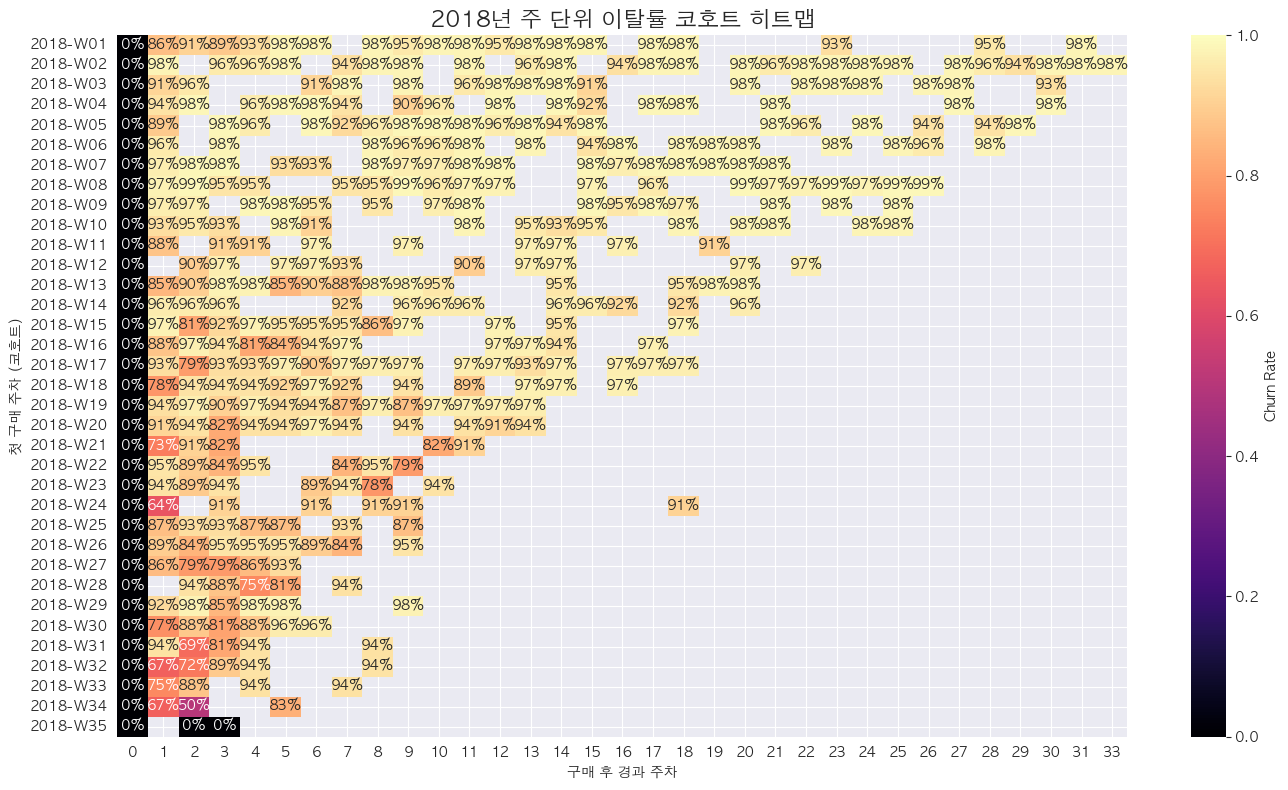

In [110]:
# 연도 추출 (cohort_week 예: '2016-W01')
cohort_data['cohort_year'] = cohort_data['cohort_week'].str[:4]

# 연도별 반복 시각화
for year in ['2016', '2017', '2018']:
    # 해당 연도 데이터 필터링
    cohort_year_data = cohort_data[cohort_data['cohort_year'] == year]

    # 피벗 테이블 생성
    churn_pivot = cohort_year_data.pivot(
        index='cohort_week',
        columns='weeks_since_first',
        values='churn_rate'
    )

    # 히트맵 시각화
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        churn_pivot,
        annot=True,
        fmt=".0%",
        cmap='magma',
        vmin=0.0,
        vmax=1.0,
        cbar_kws={'label': 'Churn Rate'}
    )

    plt.title(f'{year}년 주 단위 이탈률 코호트 히트맵', fontsize=16)
    plt.xlabel('구매 후 경과 주차')
    plt.ylabel('첫 구매 주차 (코호트)')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [111]:
# 마지막 구매일 : 2018-10-16 20:16:02
filtered_customers['order_purchase_timestamp'].describe()

count                             6099
mean     2017-12-09 05:09:45.234956544
min                2016-10-03 09:44:50
25%         2017-08-14 15:59:22.500000
50%                2017-12-17 18:45:57
75%         2018-04-08 12:52:17.500000
max                2018-10-16 20:16:02
Name: order_purchase_timestamp, dtype: object

In [112]:
# 2. 주문 시간 기준으로 정렬
filtered_customers_sorted = filtered_customers.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])

# 3. 각 고객의 주문 순번 부여
filtered_customers_sorted['order_rank'] = filtered_customers_sorted.groupby('customer_unique_id').cumcount() + 1

# 4. 첫 번째, 두 번째 주문만 필터링
first_second_orders = filtered_customers_sorted[filtered_customers_sorted['order_rank'].isin([1, 2])]

# 5. 첫 번째와 두 번째 구매만 남긴 후 reshape
order_diff_df = first_second_orders.pivot(index='customer_unique_id', columns='order_rank', values='order_purchase_timestamp')
order_diff_df.columns = ['first_order', 'second_order']  # rank 1, 2에 맞게 이름 지정

# 6. 소요일 계산 (두 번째 - 첫 번째)
order_diff_df['days_between'] = (order_diff_df['second_order'] - order_diff_df['first_order']).dt.days

# 7. 결과 확인
print(order_diff_df[['first_order', 'second_order', 'days_between']].head())

# 평균 소요일: 약 80일(2~3개월) 중위값(28일)
average_days = order_diff_df['days_between'].mean()
print(f"평균 소요일: {average_days:.2f}일")
order_diff_df['days_between'].describe()

                                         first_order        second_order  \
customer_unique_id                                                         
00172711b30d52eea8b313a7f2cced02 2018-07-28 00:23:49 2018-08-13 09:14:07   
004288347e5e88a27ded2bb23747066c 2017-07-27 14:13:03 2018-01-14 07:36:54   
004b45ec5c64187465168251cd1c9c2f 2017-09-01 12:11:23 2018-05-26 19:42:48   
0058f300f57d7b93c477a131a59b36c3 2018-02-19 17:11:34 2018-03-22 18:09:41   
00a39521eb40f7012db50455bf083460 2018-05-23 20:14:21 2018-06-03 10:12:57   

                                  days_between  
customer_unique_id                              
00172711b30d52eea8b313a7f2cced02            16  
004288347e5e88a27ded2bb23747066c           170  
004b45ec5c64187465168251cd1c9c2f           267  
0058f300f57d7b93c477a131a59b36c3            31  
00a39521eb40f7012db50455bf083460            10  
평균 소요일: 80.40일


count    2948.00000
mean       80.40095
std       110.34067
min         0.00000
25%         0.00000
50%        28.00000
75%       124.00000
max       608.00000
Name: days_between, dtype: float64

In [113]:
# 3회 구매 고객
customers_3 = purchase_frequency[purchase_frequency['purchase_count'] == 3]
customers_3 = filtered_customers[filtered_customers['customer_unique_id'].isin(customers_3['customer_unique_id'])]

customers_3.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,order_rank,order_month
52,d85c2deca369a3930811855341fb3d11,14676dd9c40ad83f2a980ac36077cdb9,delivered,2017-11-23 16:19:10,2017-11-24 03:09:58,2017-11-25 00:32:48,2017-12-02 14:38:11,2017-12-19 00:00:00,02e9109b7e0a985108b43e573b6afb23,1,2017-11-01
53,eb7df5ec433a5660c84c3a2e1bce192d,76525f0c94f889d91e4335fae56eaaaf,delivered,2018-05-13 23:53:10,2018-05-15 03:55:50,2018-05-15 13:59:00,2018-05-19 12:34:47,2018-06-05 00:00:00,02e9109b7e0a985108b43e573b6afb23,2,2018-05-01
54,a7076e7aba13de8b66d95a55811290ed,1ae196062dab95e434e781a5319f0ab9,delivered,2018-05-14 11:04:55,2018-05-15 04:35:02,2018-05-15 16:22:00,2018-05-21 20:32:38,2018-06-04 00:00:00,02e9109b7e0a985108b43e573b6afb23,3,2018-05-01
83,129538e4bc7308e9ab041540283813f2,482da0f3d74585e56f424bacb4d3741c,delivered,2017-03-15 21:50:14,2017-03-15 21:50:14,2017-03-17 06:34:15,2017-03-23 16:08:02,2017-04-03 00:00:00,041caba6a63ace5818387698ea85cdb2,1,2017-03-01
84,7f2f81a366f89b37109845799fc5bbf3,844cb4ee61b1b92e94afbe24cb04edf8,delivered,2017-11-17 08:47:41,2017-11-17 09:06:58,2017-11-23 18:37:07,2017-11-29 22:34:41,2017-11-30 00:00:00,041caba6a63ace5818387698ea85cdb2,2,2017-11-01


In [114]:
# 3회 구매 고객: 첫 번째 구매 이후 두 번째 구매까지 소요일

# 2. 주문 시간 기준으로 정렬
customers_3_sorted = customers_3.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])

# 3. 각 고객의 주문 순번 부여
customers_3_sorted['order_rank'] = customers_3_sorted.groupby('customer_unique_id').cumcount() + 1

# 4. 첫 번째, 두 번째 주문만 필터링
first_second_orders = customers_3_sorted[customers_3_sorted['order_rank'].isin([1, 2])]

# 5. 첫 번째와 두 번째 구매만 남긴 후 reshape
order_diff_df = first_second_orders.pivot(index='customer_unique_id', columns='order_rank', values='order_purchase_timestamp')
order_diff_df.columns = ['first_order', 'second_order']  # rank 1, 2에 맞게 이름 지정

# 6. 소요일 계산 (두 번째 - 첫 번째)
order_diff_df['days_between'] = (order_diff_df['second_order'] - order_diff_df['first_order']).dt.days

# 7. 결과 확인
print(order_diff_df[['first_order', 'second_order', 'days_between']].head())

# 평균 소요일: 약 74일(2~3개월)
average_days = order_diff_df['days_between'].mean()
print(f"평균 소요일: {average_days:.2f}일")

                                         first_order        second_order  \
customer_unique_id                                                         
02e9109b7e0a985108b43e573b6afb23 2017-11-23 16:19:10 2018-05-13 23:53:10   
041caba6a63ace5818387698ea85cdb2 2017-03-15 21:50:14 2017-11-17 08:47:41   
043aee247e71edff7045664609f4d806 2017-03-22 12:29:08 2017-05-25 16:12:51   
06a52782a04f0086d16b9c22d0e29438 2017-05-06 20:11:10 2017-05-06 20:11:10   
07b1b60bca2b6326fa2adb259ea4a55f 2018-03-26 22:19:07 2018-03-30 15:47:09   

                                  days_between  
customer_unique_id                              
02e9109b7e0a985108b43e573b6afb23           171  
041caba6a63ace5818387698ea85cdb2           246  
043aee247e71edff7045664609f4d806            64  
06a52782a04f0086d16b9c22d0e29438             0  
07b1b60bca2b6326fa2adb259ea4a55f             3  
평균 소요일: 74.28일


In [115]:
order_diff_df['days_between'].describe() # 중위값: 33일

count    203.000000
mean      74.275862
std       99.488308
min        0.000000
25%        0.000000
50%       33.000000
75%      112.000000
max      509.000000
Name: days_between, dtype: float64

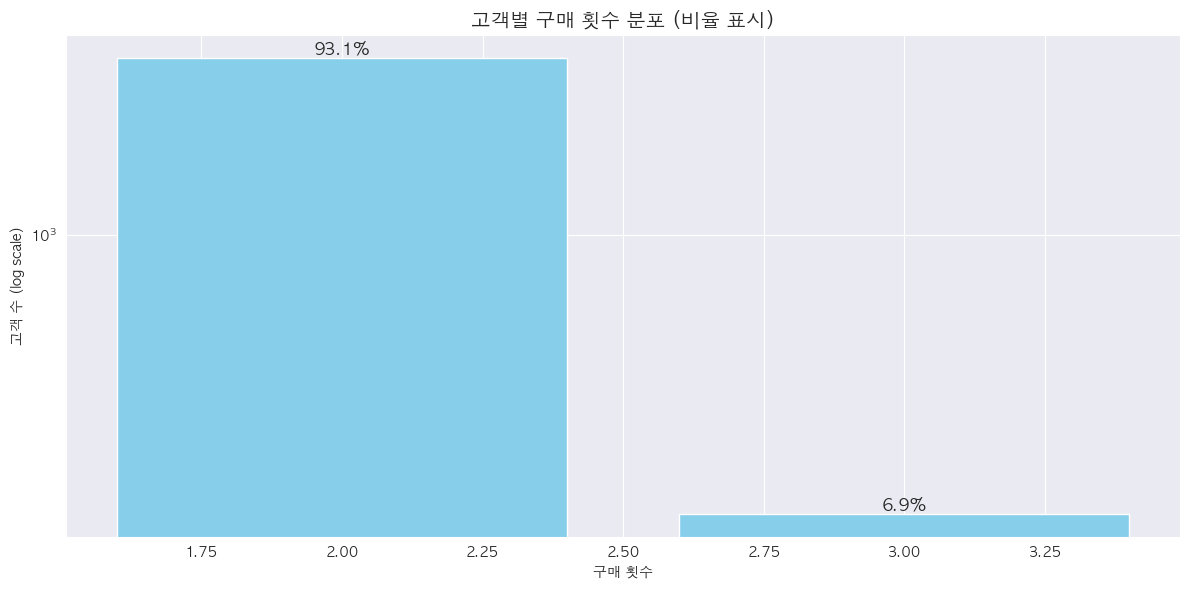

In [116]:
plt.figure(figsize=(12, 6))
bars = plt.bar(counts.index, counts.values, color='skyblue')

plt.yscale('log')  # 로그 스케일
plt.title('고객별 구매 횟수 분포 (비율 표시)', fontsize=14)
plt.xlabel('구매 횟수')
plt.ylabel('고객 수 (log scale)')
plt.grid(True)

# 막대 위에 비율 (%) 표시
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    if height > 0:  # 0인 경우 표시 생략
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{pct:.1f}%',
                 ha='center', va='bottom', fontsize=12, rotation=0)

plt.tight_layout()
plt.show()

In [117]:
# 2회 구매 고객
customers_2 = purchase_frequency[purchase_frequency['purchase_count'] == 2]
customers_2 = filtered_customers[filtered_customers['customer_unique_id'].isin(customers_2['customer_unique_id'])]

customers_2.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,order_rank,order_month
0,bb874c45df1a3c97842d52f31efee99a,1afe8a9c67eec3516c09a8bdcc539090,delivered,2018-07-28 00:23:49,2018-07-28 00:35:19,2018-07-31 15:57:00,2018-08-07 19:28:41,2018-08-22 00:00:00,00172711b30d52eea8b313a7f2cced02,1,2018-07-01
1,c306eca42d32507b970739b5b6a5a33a,24b0e2bd287e47d54d193e7bbb51103f,canceled,2018-08-13 09:14:07,NaN,NaN,NaN,2018-09-05 00:00:00,00172711b30d52eea8b313a7f2cced02,2,2018-08-01
2,a61d617fbe5bd006e40d3a0988fc844b,1b4a75b3478138e99902678254b260f4,delivered,2017-07-27 14:13:03,2017-07-27 14:25:14,2017-07-28 17:45:36,2017-08-04 16:26:54,2017-08-18 00:00:00,004288347e5e88a27ded2bb23747066c,1,2017-07-01
3,08204559bebd39e09ee52dcb56d8faa2,f6efe5d5c7b85e12355f9d5c3db46da2,delivered,2018-01-14 07:36:54,2018-01-14 07:49:28,2018-01-16 16:39:34,2018-01-19 22:14:14,2018-02-09 00:00:00,004288347e5e88a27ded2bb23747066c,2,2018-01-01
4,90ae229a4addcfead792e2564554f09c,49cf243e0d353cd418ca77868e24a670,shipped,2017-09-01 12:11:23,2017-09-05 04:30:20,2017-09-08 19:42:16,NaN,2017-10-06 00:00:00,004b45ec5c64187465168251cd1c9c2f,1,2017-09-01


In [118]:
# 2회 구매 고객:  첫 번째 구매 이후 두 번째 구매까지 소요일

# 2. 고객별 주문 시간 순으로 정렬
customers_2_sorted = customers_2.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])

# 3. 각 고객의 주문 순번 부여
customers_2_sorted['order_rank'] = customers_2_sorted.groupby('customer_unique_id').cumcount() + 1

# 4. 첫 번째, 두 번째 주문만 필터링
first_second_orders = customers_2_sorted[customers_2_sorted['order_rank'].isin([1, 2])]

# 5. Pivot: 첫 번째와 두 번째 구매 시간 분리
order_diff_df = first_second_orders.pivot(index='customer_unique_id', columns='order_rank', values='order_purchase_timestamp')
order_diff_df.columns = ['first_order', 'second_order']  # 컬럼명 명확히 지정

# 6. 소요일 계산 (second - first)
order_diff_df['days_between'] = (order_diff_df['second_order'] - order_diff_df['first_order']).dt.days

# 7. 결과 확인
print(order_diff_df[['first_order', 'second_order', 'days_between']].head())

# 평균 소요일: 80일(2~3개월)
average_days = order_diff_df['days_between'].mean()
print(f"2회 구매 고객의 평균 소요일: {average_days:.2f}일")

                                         first_order        second_order  \
customer_unique_id                                                         
00172711b30d52eea8b313a7f2cced02 2018-07-28 00:23:49 2018-08-13 09:14:07   
004288347e5e88a27ded2bb23747066c 2017-07-27 14:13:03 2018-01-14 07:36:54   
004b45ec5c64187465168251cd1c9c2f 2017-09-01 12:11:23 2018-05-26 19:42:48   
0058f300f57d7b93c477a131a59b36c3 2018-02-19 17:11:34 2018-03-22 18:09:41   
00a39521eb40f7012db50455bf083460 2018-05-23 20:14:21 2018-06-03 10:12:57   

                                  days_between  
customer_unique_id                              
00172711b30d52eea8b313a7f2cced02            16  
004288347e5e88a27ded2bb23747066c           170  
004b45ec5c64187465168251cd1c9c2f           267  
0058f300f57d7b93c477a131a59b36c3            31  
00a39521eb40f7012db50455bf083460            10  
2회 구매 고객의 평균 소요일: 80.85일


In [119]:
order_diff_df['days_between'].describe() # 중위값: 28일

count    2745.000000
mean       80.853916
std       111.104238
min         0.000000
25%         0.000000
50%        28.000000
75%       125.000000
max       608.000000
Name: days_between, dtype: float64

# products_dataset

In [120]:
products_df = pd.read_csv('data/olist_products_dataset.csv')
products_df.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [121]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [122]:
products_df.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [123]:
products_df.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


In [124]:
# 등록 카테고리 수: 73건
products_df['product_category_name'].nunique()

73

# 이탈 요인 분석

## Products_dataset

In [125]:
products_df.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [126]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [127]:
# 사진 개수
products_df['product_photos_qty'].describe()

count    32341.000000
mean         2.188986
std          1.736766
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         20.000000
Name: product_photos_qty, dtype: float64

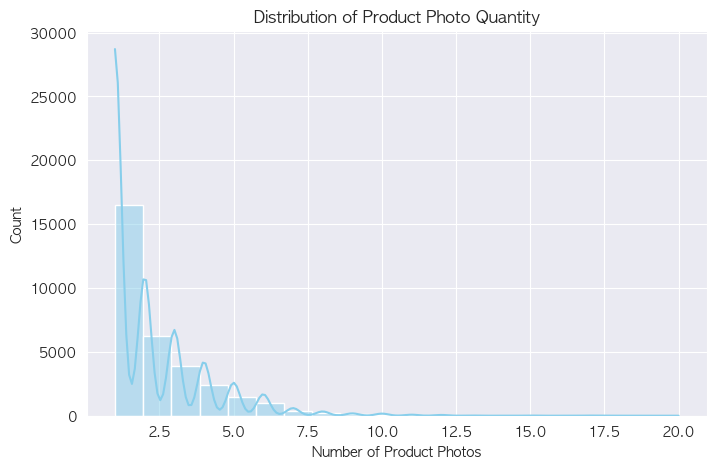

In [128]:
plt.figure(figsize=(8, 5))
sns.histplot(products_df['product_photos_qty'], bins=20, kde=True, color='skyblue')
plt.xlabel('Number of Product Photos')
plt.ylabel('Count')
plt.title('Distribution of Product Photo Quantity')
plt.show()

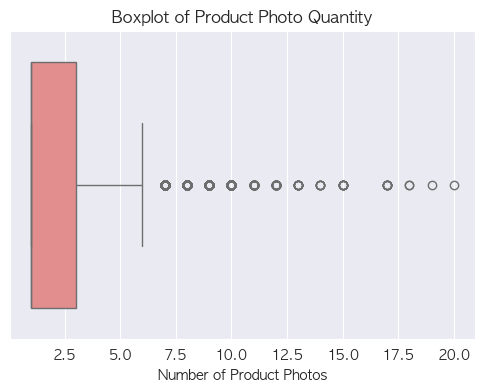

In [129]:
# 이상치
plt.figure(figsize=(6, 4))
sns.boxplot(x=products_df['product_photos_qty'], color='lightcoral')
plt.xlabel('Number of Product Photos')
plt.title('Boxplot of Product Photo Quantity')
plt.show()

In [130]:
# 사분위수 계산
Q1 = products_df['product_photos_qty'].quantile(0.25)
Q3 = products_df['product_photos_qty'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 경계
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 제거
filtered_df = products_df[
    (products_df['product_photos_qty'] >= lower_bound) &
    (products_df['product_photos_qty'] <= upper_bound)
]

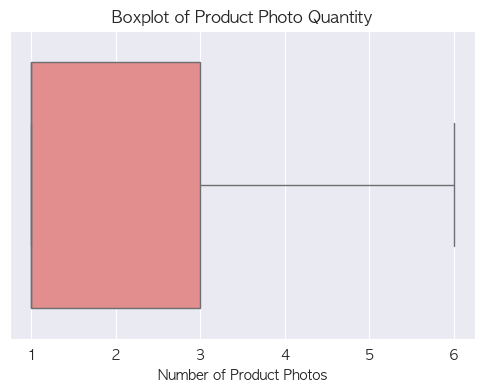

In [131]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=filtered_df['product_photos_qty'], color='lightcoral')
plt.xlabel('Number of Product Photos')
plt.title('Boxplot of Product Photo Quantity')
plt.show()

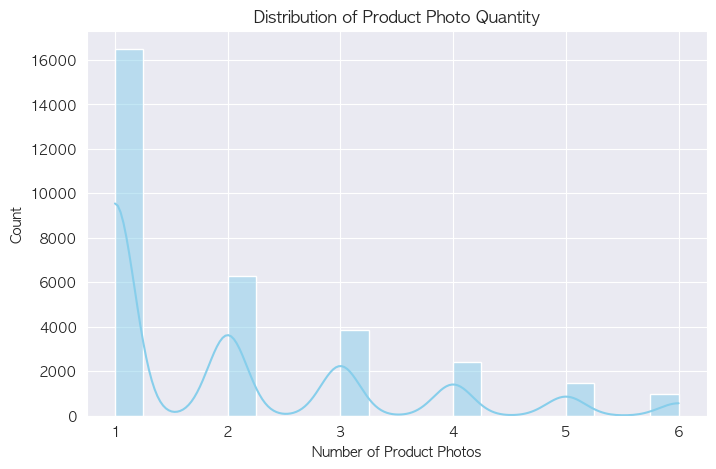

In [132]:
plt.figure(figsize=(8, 5))
sns.histplot(filtered_df['product_photos_qty'], bins=20, kde=True, color='skyblue')
plt.xlabel('Number of Product Photos')
plt.ylabel('Count')
plt.title('Distribution of Product Photo Quantity')
plt.show()

In [133]:
# Box-Cox 변환 (왼쪽 비대칭에도 적합)
from scipy import stats

# 0 이상 값만 사용 가능
positive_vals = filtered_df[filtered_df['product_photos_qty'] > 0]['product_photos_qty']

# Box-Cox 변환
boxcox_transformed, fitted_lambda = stats.boxcox(positive_vals)

# 변환 결과를 새로운 컬럼으로 저장
filtered_df = filtered_df.copy()
filtered_df.loc[positive_vals.index, 'product_photos_qty_boxcox'] = boxcox_transformed

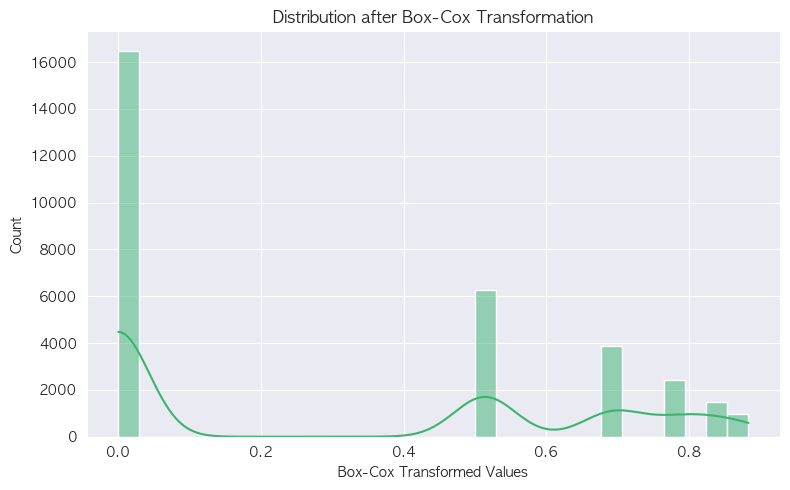

In [134]:
plt.figure(figsize=(8, 5))

sns.histplot(boxcox_transformed, bins=30, kde=True, color='mediumseagreen')
plt.title('Distribution after Box-Cox Transformation')
plt.xlabel('Box-Cox Transformed Values')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [135]:
merged3_df = pd.merge(
    rfm_df,
    orders_df[['customer_unique_id', 'order_id']],
    on='customer_unique_id',
    how='left'
)

merged3_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6342 entries, 0 to 6341
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   customer_unique_id  6342 non-null   object  
 1   Recency             6342 non-null   int64   
 2   Frequency           6342 non-null   int64   
 3   Monetary            6342 non-null   float64 
 4   Frequency_level     6342 non-null   category
 5   F_score             6342 non-null   int64   
 6   R_quantile          6342 non-null   int64   
 7   M_quantile          6342 non-null   int64   
 8   R_score             6342 non-null   int64   
 9   M_score             6342 non-null   int64   
 10  RFM_score           6342 non-null   object  
 11  churn               6342 non-null   int64   
 12  order_id            6342 non-null   object  
dtypes: category(1), float64(1), int64(8), object(3)
memory usage: 601.0+ KB


In [136]:
# 병합 전 중복 컬럼 제거
order_items_df = order_items_df.drop(columns=['product_photos_qty_boxcox'], errors='ignore')

# 병합 수행
order_items_df = pd.merge(
    order_items_df,
    filtered_df[['product_id', 'product_photos_qty', 'product_photos_qty_boxcox']],
    on='product_id',
    how='left'
)

# 이어서 두 번째 병합
merged_items = pd.merge(
    order_items_df,
    merged3_df[['order_id', 'Recency', 'Frequency_level', 'Monetary', 'churn']],
    on='order_id',
    how='right'
)

merged_items.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7675 entries, 0 to 7674
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   order_id                   7675 non-null   object  
 1   order_item_id              7568 non-null   float64 
 2   product_id                 7568 non-null   object  
 3   seller_id                  7568 non-null   object  
 4   shipping_limit_date        7568 non-null   object  
 5   price                      7568 non-null   float64 
 6   freight_value              7568 non-null   float64 
 7   product_photos_qty         7319 non-null   float64 
 8   product_photos_qty_boxcox  7319 non-null   float64 
 9   Recency                    7675 non-null   int64   
 10  Frequency_level            7675 non-null   category
 11  Monetary                   7675 non-null   float64 
 12  churn                      7675 non-null   int64   
dtypes: category(1), float64(6), int64

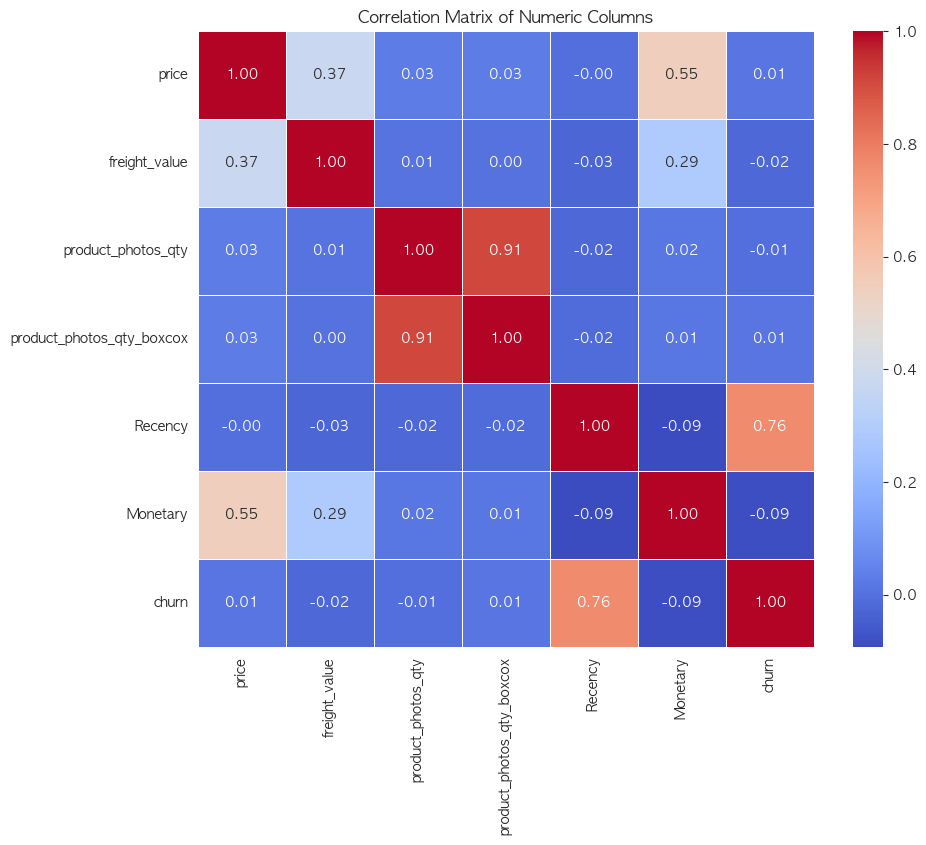

In [137]:
# 숫자형 컬럼만 추출
numeric_cols = merged_items.select_dtypes(include=['number'])
numeric_cols = numeric_cols.drop(columns=['order_item_id'], errors='ignore')

# 상관계수 계산 (피어슨 기본)
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

In [138]:
merged_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7675 entries, 0 to 7674
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   order_id                   7675 non-null   object  
 1   order_item_id              7568 non-null   float64 
 2   product_id                 7568 non-null   object  
 3   seller_id                  7568 non-null   object  
 4   shipping_limit_date        7568 non-null   object  
 5   price                      7568 non-null   float64 
 6   freight_value              7568 non-null   float64 
 7   product_photos_qty         7319 non-null   float64 
 8   product_photos_qty_boxcox  7319 non-null   float64 
 9   Recency                    7675 non-null   int64   
 10  Frequency_level            7675 non-null   category
 11  Monetary                   7675 non-null   float64 
 12  churn                      7675 non-null   int64   
dtypes: category(1), float64(6), int64

In [139]:
print("📊 [통계 요약: product_photos_qty by churn]")
print(merged_items.groupby('churn')['product_photos_qty'].describe())

📊 [통계 요약: product_photos_qty by churn]
        count      mean       std  min  25%  50%  75%  max
churn                                                     
0      4784.0  1.938963  1.375100  1.0  1.0  1.0  2.0  6.0
1      2535.0  1.918343  1.291722  1.0  1.0  1.0  2.0  6.0


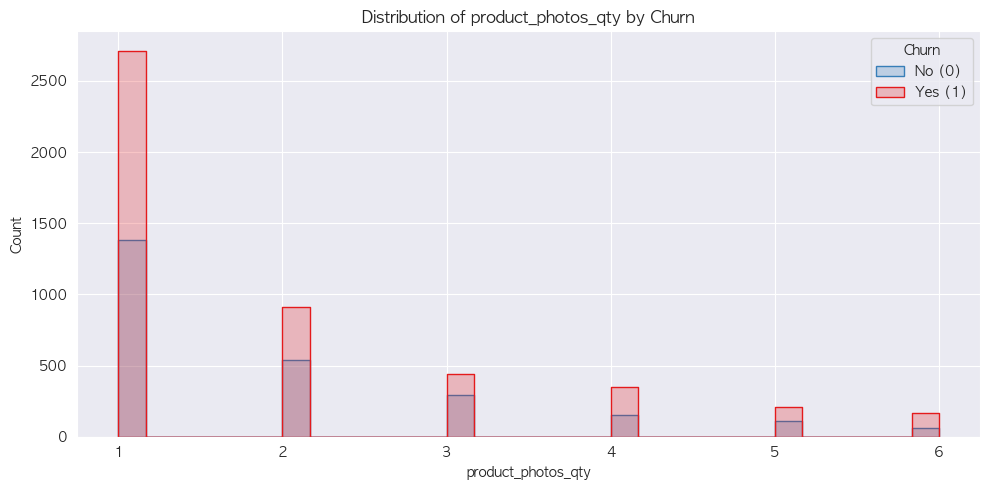

In [140]:
plt.figure(figsize=(10, 5))
sns.histplot(data=merged_items, x='product_photos_qty', hue='churn', bins=30, palette='Set1', element='step')
plt.title('Distribution of product_photos_qty by Churn')
plt.xlabel('product_photos_qty')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No (0)', 'Yes (1)'])
plt.tight_layout()
plt.show()

## reviews_dataset

In [141]:
filtered_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6748 entries, 28 to 99214
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                6748 non-null   object
 1   order_id                 6748 non-null   object
 2   review_score             6748 non-null   int64 
 3   review_comment_title     686 non-null    object
 4   review_comment_message   2751 non-null   object
 5   review_creation_date     6748 non-null   object
 6   review_answer_timestamp  6748 non-null   object
 7   customer_unique_id       6748 non-null   object
dtypes: int64(1), object(7)
memory usage: 474.5+ KB


In [142]:
merged_reviews = pd.merge(
    filtered_reviews,
    merged3_df[['order_id', 'Recency', 'Frequency_level', 'Monetary', 'churn']],
    on='order_id',
    how='left')

merged_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6748 entries, 0 to 6747
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   review_id                6748 non-null   object  
 1   order_id                 6748 non-null   object  
 2   review_score             6748 non-null   int64   
 3   review_comment_title     686 non-null    object  
 4   review_comment_message   2751 non-null   object  
 5   review_creation_date     6748 non-null   object  
 6   review_answer_timestamp  6748 non-null   object  
 7   customer_unique_id       6748 non-null   object  
 8   Recency                  6748 non-null   int64   
 9   Frequency_level          6748 non-null   category
 10  Monetary                 6748 non-null   float64 
 11  churn                    6748 non-null   int64   
dtypes: category(1), float64(1), int64(3), object(7)
memory usage: 586.8+ KB


In [143]:
rfm_df = merged_df2[['customer_unique_id', 'order_purchase_timestamp', 'order_id', 'payment_value']]
rfm_df.head()

,customer_unique_id,order_purchase_timestamp,order_id,payment_value
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,18.12
1,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,2.00
2,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,18.59
3,ccafc1c3f270410521c3c6f3b249870f,2018-06-07 19:03:12,dcb36b511fcac050b97cd5c05de84dc3,146.45
4,6e26bbeaa107ec34112c64e1ee31c0f5,2018-01-02 19:00:43,403b97836b0c04a622354cf531062e5f,1376.45


In [144]:
merged_reviews['customer_unique_id'].nunique()

2988

In [147]:
order_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
 7   customer_unique_id       99224 non-null  object
dtypes: int64(1), object(7)
memory usage: 6.1+ MB


In [148]:
order_reviews_df['customer_unique_id'].nunique()

95380

In [149]:
# 날짜 컬럼을 datetime 형식으로 변환
merged_reviews['review_creation_date'] = pd.to_datetime(merged_reviews['review_creation_date'])
merged_reviews['review_answer_timestamp'] = pd.to_datetime(merged_reviews['review_answer_timestamp'])

# 날짜 차이 계산 (답변까지 걸린 시간)
merged_reviews['response_time'] = merged_reviews['review_answer_timestamp'] - merged_reviews['review_creation_date']

# 결과 확인
print(merged_reviews[['review_creation_date', 'review_answer_timestamp', 'response_time']].head())

  review_creation_date review_answer_timestamp   response_time
0           2018-03-29     2018-04-02 14:19:31 4 days 14:19:31
1           2018-01-18     2018-01-18 19:12:30 0 days 19:12:30
2           2017-05-19     2017-05-21 03:04:35 2 days 03:04:35
3           2017-03-21     2017-03-22 00:58:49 1 days 00:58:49
4           2018-06-19     2018-06-19 17:44:05 0 days 17:44:05


In [150]:
# 일 단위 응답 시간
merged_reviews['response_days'] = merged_reviews['response_time'].dt.days
print(merged_reviews['response_days'].describe())

count    6748.000000
mean        2.447244
std         9.504114
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       367.000000
Name: response_days, dtype: float64


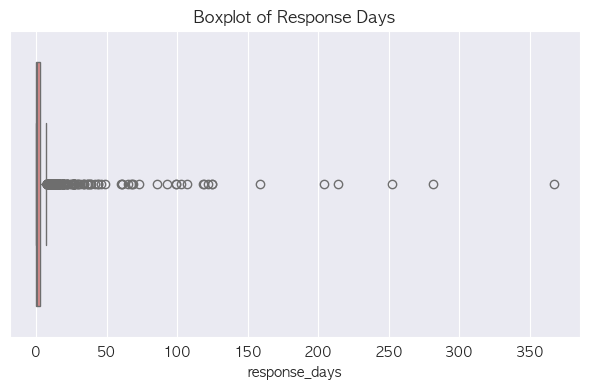

In [151]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=merged_reviews['response_days'], color='lightcoral')
plt.title('Boxplot of Response Days')
plt.xlabel('response_days')
plt.tight_layout()
plt.show()

In [152]:
Q1 = merged_reviews['response_days'].quantile(0.25)
Q3 = merged_reviews['response_days'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 제거
filtered_df = merged_reviews[(merged_reviews['response_days'] >= lower_bound) &
                             (merged_reviews['response_days'] <= upper_bound)]

/var/folders/x3/rnzg2dn97bl4ky25jynn9l0m0000gn/T/ipykernel_44639/2389902768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['log_response_days'] = np.log1p(filtered_df['response_days'])


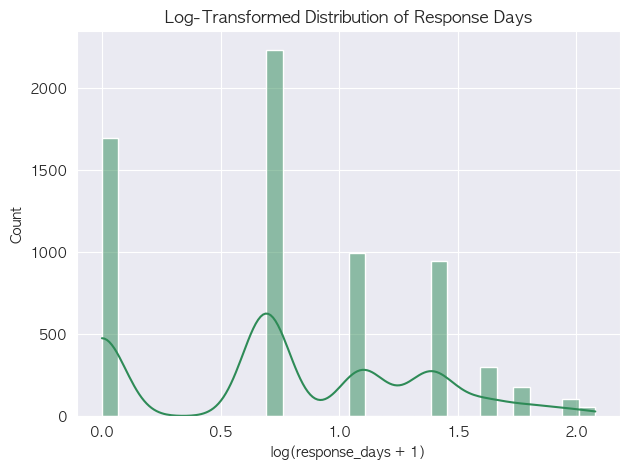

In [154]:
filtered_df['log_response_days'] = np.log1p(filtered_df['response_days'])

sns.histplot(filtered_df['log_response_days'], bins=30, kde=True, color='seagreen')
plt.title('Log-Transformed Distribution of Response Days')
plt.xlabel('log(response_days + 1)')
plt.tight_layout()
plt.show()

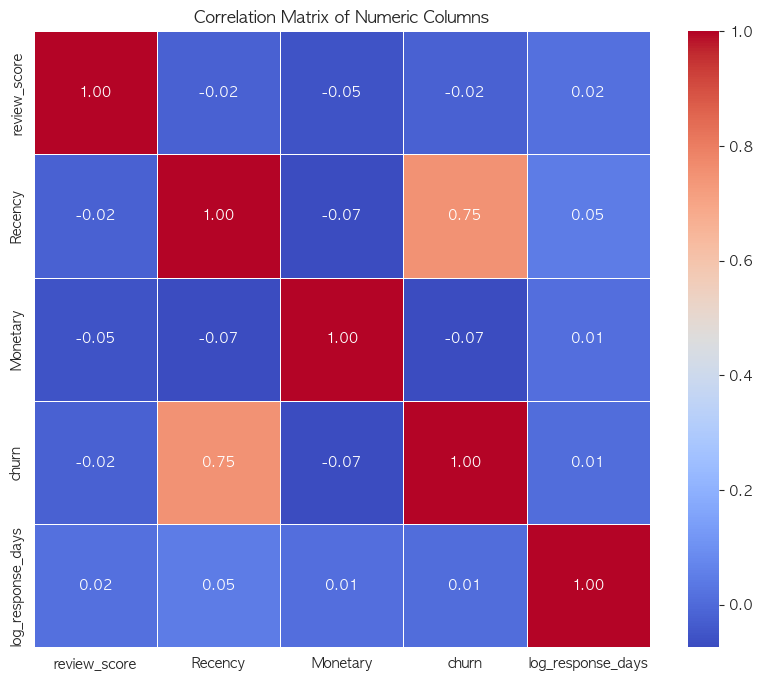

In [156]:
# 숫자형 컬럼만 추출
numeric_cols = filtered_df.select_dtypes(include=['number'])
numeric_cols = numeric_cols.drop(columns=['response_time', 'response_days'], errors='ignore')

# 상관계수 계산 (피어슨 기본)
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

In [157]:
print("📊 [통계 요약: response_days by churn]")
print(filtered_df.groupby('churn')['response_days'].describe())

📊 [통계 요약: response_days by churn]
        count      mean       std  min  25%  50%  75%  max
churn                                                     
0      4162.0  1.561989  1.509603  0.0  0.0  1.0  2.0  7.0
1      2357.0  1.569792  1.488748  0.0  1.0  1.0  2.0  7.0


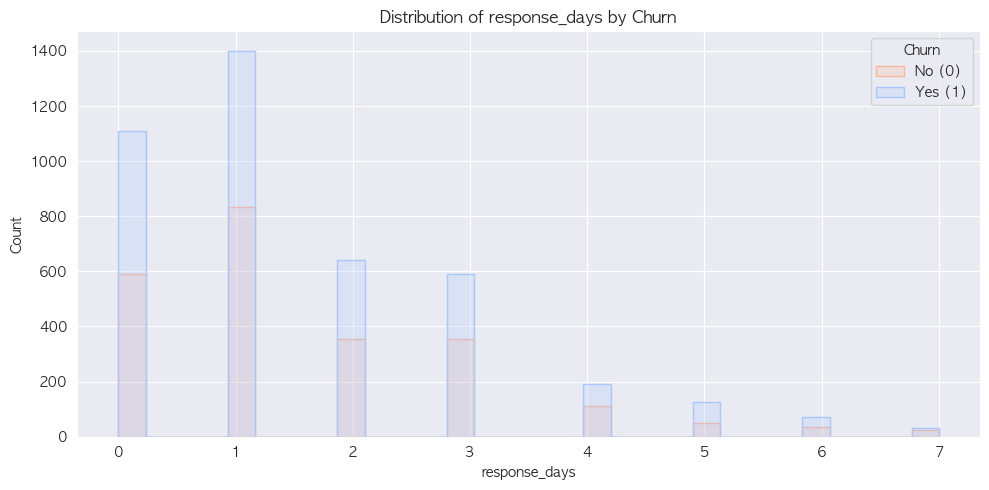

In [158]:
plt.figure(figsize=(10, 5))
sns.histplot(data=filtered_df, x='response_days', hue='churn', bins=30, element='step', palette='coolwarm')
plt.title('Distribution of response_days by Churn')
plt.xlabel('response_days')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No (0)', 'Yes (1)'])
plt.tight_layout()
plt.show()

# 행동 패턴 분석

In [159]:
unique_customer_df.head()

,customer_unique_id,unique_order_count,unique_city_count,unique_state_count
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17,1,1
23472,3e43e6105506432c953e165fb2acf44c,9,1,1
37797,6469f99c1f9dfae7733b25662e7f1782,7,1,1
76082,ca77025e7201e3b30c44b472ff346268,7,1,1
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7,1,1


In [160]:
order_reviews_df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,68a5590b9926689be4e10f4ae2db21a8
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,64190b91b656ab8f37eb89b93dc84584
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,1d47144362c14e94ccdd213e8ec277d5
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,c8cf6cb6b838dc7a33ed199b825e8616
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,d16000272660a1fef81482ad75ba572a


In [161]:
order_payments_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [162]:
reviews_pay = pd.merge(
    order_reviews_df,
    order_payments_df[['order_id', 'payment_value']],
    on='order_id',
    how='left')

reviews_pay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103678 entries, 0 to 103677
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   review_id                103678 non-null  object 
 1   order_id                 103678 non-null  object 
 2   review_score             103678 non-null  int64  
 3   review_comment_title     11996 non-null   object 
 4   review_comment_message   42816 non-null   object 
 5   review_creation_date     103678 non-null  object 
 6   review_answer_timestamp  103678 non-null  object 
 7   customer_unique_id       103678 non-null  object 
 8   payment_value            103677 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 7.1+ MB


In [163]:
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6


In [164]:
reviews_pay_orders = pd.merge(
    reviews_pay,
    orders_df[['order_id', 'order_purchase_timestamp']],
    on='order_id',
    how='left')

reviews_pay_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103678 entries, 0 to 103677
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   review_id                 103678 non-null  object        
 1   order_id                  103678 non-null  object        
 2   review_score              103678 non-null  int64         
 3   review_comment_title      11996 non-null   object        
 4   review_comment_message    42816 non-null   object        
 5   review_creation_date      103678 non-null  object        
 6   review_answer_timestamp   103678 non-null  object        
 7   customer_unique_id        103678 non-null  object        
 8   payment_value             103677 non-null  float64       
 9   order_purchase_timestamp  103678 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 7.9+ MB


In [165]:
all_rfm_df = reviews_pay_orders.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': 'max',
    'order_id': pd.Series.nunique,
    'payment_value': 'sum'
})
all_rfm_df = all_rfm_df.rename(columns={
    'order_purchase_timestamp': 'Recency', # 최근 구매 경과일
    'order_id': 'Frequency', # 구매 빈도
    'payment_value': 'Monetary' # 총 구매금액
})
all_rfm_df.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,27.19
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,43.62
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,196.89


In [166]:
# Recency 날짜형을 숫자형으로 변환
max_date = all_rfm_df['Recency'].max()
all_rfm_df['Recency'] = max_date - all_rfm_df['Recency'] # timedelta 자료형
all_rfm_df['Recency']

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2   160 days 06:33:51
0000b849f77a49e4a4ce2b2a4ca5be3f   163 days 06:18:51
0000f46a3911fa3c0805444483337064   585 days 20:25:15
0000f6ccb0745a6a4b88665a16c9f078   369 days 21:00:37
0004aac84e0df4da2b147fca70cf8255   336 days 21:44:36
                                          ...       
fffcf5a5ff07b0908bd4e2dbc735a684   495 days 20:29:42
fffea47cd6d3cc0a88bd621562a9d061   310 days 21:22:22
ffff371b4d645b6ecea244b27531430a   617 days 01:41:02
ffff5962728ec6157033ef9805bacc48   168 days 02:12:37
ffffd2657e2aad2907e67c3e9daecbeb   532 days 21:11:33
Name: Recency, Length: 95380, dtype: timedelta64[ns]

In [167]:
all_rfm_df['Recency'] = all_rfm_df['Recency'].apply(lambda x: x.days + 1)
all_rfm_df.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19
0000f46a3911fa3c0805444483337064,586,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62
0004aac84e0df4da2b147fca70cf8255,337,1,196.89


In [168]:
# 구간 설정 및 범주 이름 지정
bins = [0, 2, 5, float('inf')]  # 0~2: low, 3~5: mid, 6~: high
labels = ['low', 'mid', 'high']

# 구간화
all_rfm_df['Frequency_level'] = pd.cut(all_rfm_df['Frequency'], bins=bins, labels=labels)

all_rfm_df.head()

,Recency,Frequency,Monetary,Frequency_level
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,low
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,low
0000f46a3911fa3c0805444483337064,586,1,86.22,low
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,low
0004aac84e0df4da2b147fca70cf8255,337,1,196.89,low


In [169]:
# 매핑 딕셔너리 정의
f_score_map = {
    'low': 1,
    'mid': 3,
    'high': 5
}

# Categorical 컬럼을 문자열로 변환 후 매핑
all_rfm_df['F_score'] = all_rfm_df['Frequency_level'].astype(str).map(f_score_map).fillna(2).astype(int)

In [171]:
# 분위수 구간 계산 (NaN 발생 대비 + 분위수 구간 부족 대비)
for col in ['Recency', 'Monetary']:
    try:
        all_rfm_df[col[0] + '_quantile'] = pd.qcut(
            all_rfm_df[col],
            5,
            labels=False,
            duplicates='drop'
        )
    except ValueError:
        # 전부 동일하거나 분위수 계산 불가한 경우 → 값 전체를 중간값으로 처리
        all_rfm_df[col[0] + '_quantile'] = 2

# NaN이 생긴 경우 기본값 2로 대체
all_rfm_df[['R_quantile', 'M_quantile']] = all_rfm_df[['R_quantile', 'M_quantile']].fillna(2)

# RFM 점수 계산
all_rfm_df['R_score'] = (5 - all_rfm_df['R_quantile']).astype(int)  # Recency는 낮을수록 높게
all_rfm_df['M_score'] = (1 + all_rfm_df['M_quantile']).astype(int)

# 최종 RFM Score 조합
all_rfm_df['RFM_score'] = (
    all_rfm_df['R_score'].astype(str) +
    all_rfm_df['F_score'].astype(str) +
    all_rfm_df['M_score'].astype(str)
)

# 결과 출력
print(all_rfm_df[['Recency', 'Frequency', 'Monetary', 'R_score', 'F_score', 'M_score', 'RFM_score']])

                                  Recency  Frequency  Monetary  R_score  \
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2      161          1    141.90        4   
0000b849f77a49e4a4ce2b2a4ca5be3f      164          1     27.19        4   
0000f46a3911fa3c0805444483337064      586          1     86.22        1   
0000f6ccb0745a6a4b88665a16c9f078      370          1     43.62        2   
0004aac84e0df4da2b147fca70cf8255      337          1    196.89        2   
...                                   ...        ...       ...      ...   
fffcf5a5ff07b0908bd4e2dbc735a684      496          1   2067.42        1   
fffea47cd6d3cc0a88bd621562a9d061      311          1     84.58        3   
ffff371b4d645b6ecea244b27531430a      618          1    112.46        1   
ffff5962728ec6157033ef9805bacc48      169          1    133.69        4   
ffffd2657e2aad2907e67c3e9daecbeb      533          1     71.56        1   

                        

In [172]:
print(all_rfm_df['R_score'].value_counts())
print(all_rfm_df['F_score'].value_counts())
print(all_rfm_df['M_score'].value_counts())

R_score
2    19150
5    19100
4    19089
3    19070
1    18971
Name: count, dtype: int64
F_score
1    95134
3      235
5       11
Name: count, dtype: int64
M_score
4    19079
1    19078
2    19075
3    19075
5    19073
Name: count, dtype: int64


In [173]:
def classify_churn(row):
    if row['R_score'] <= 2 and row['F_score'] <= 2:
        return 1
    else:
        return 0

# 이탈 여부 태깅
all_rfm_df['churn'] = all_rfm_df.apply(classify_churn, axis=1)

In [174]:
all_rfm_df = all_rfm_df.reset_index()
all_rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,Frequency_level,F_score,R_quantile,M_quantile,R_score,M_score,RFM_score,churn
0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,low,1,1,3,4,4,414,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,low,1,1,0,4,1,411,0
2,0000f46a3911fa3c0805444483337064,586,1,86.22,low,1,4,1,1,2,112,1
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,low,1,3,0,2,1,211,1
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89,low,1,3,3,2,4,214,1


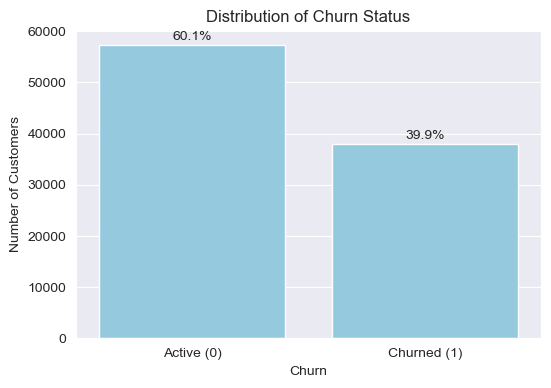

In [184]:
churn_counts = all_rfm_df['churn'].value_counts().sort_index()
total = churn_counts.sum()

plt.figure(figsize=(6,4))
ax = sns.barplot(x=churn_counts.index, y=churn_counts.values, color='skyblue')

plt.xticks([0,1], ['Active (0)', 'Churned (1)'])
plt.xlabel('Churn')
plt.ylabel('Number of Customers')
plt.title('Distribution of Churn Status')

# 막대 위에 비율 표시
for i, count in enumerate(churn_counts.values):
    percentage = count / total * 100
    ax.text(i, count + total*0.01, f'{percentage:.1f}%', ha='center')

plt.show()

In [176]:
reviews_pay_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103678 entries, 0 to 103677
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   review_id                 103678 non-null  object        
 1   order_id                  103678 non-null  object        
 2   review_score              103678 non-null  int64         
 3   review_comment_title      11996 non-null   object        
 4   review_comment_message    42816 non-null   object        
 5   review_creation_date      103678 non-null  object        
 6   review_answer_timestamp   103678 non-null  object        
 7   customer_unique_id        103678 non-null  object        
 8   payment_value             103677 non-null  float64       
 9   order_purchase_timestamp  103678 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 7.9+ MB


In [177]:
reviews_rfm = pd.merge(
    reviews_pay_orders,
    all_rfm_df[['customer_unique_id', 'churn']],
    on='customer_unique_id',
    how='left'
)

reviews_rfm.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,payment_value,order_purchase_timestamp,churn
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,68a5590b9926689be4e10f4ae2db21a8,397.26,2018-01-11 15:30:49,0
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,64190b91b656ab8f37eb89b93dc84584,88.09,2018-02-28 12:25:19,0
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,1d47144362c14e94ccdd213e8ec277d5,194.12,2018-02-03 09:56:22,0
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,c8cf6cb6b838dc7a33ed199b825e8616,222.84,2017-04-09 17:41:13,1
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,d16000272660a1fef81482ad75ba572a,1333.25,2018-02-10 10:59:03,0


In [178]:
def classify_segment(order_count):
    if order_count == 1:
        return 'Potential'
    elif order_count == 2:
        return 'Interested'
    elif order_count == 3:
        return 'New'
    else:
        return 'Loyal'

unique_customer_df['seg'] = unique_customer_df['unique_order_count'].apply(classify_segment)
print(unique_customer_df['seg'].value_counts())

seg
Potential     93099
Interested     2745
New             203
Loyal            49
Name: count, dtype: int64


In [179]:
seg_df =  pd.merge(
    reviews_rfm,
    unique_customer_df[['customer_unique_id', 'unique_order_count', 'seg']],
    on='customer_unique_id',
    how='left'
)

seg_df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,payment_value,order_purchase_timestamp,churn,unique_order_count,seg
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,68a5590b9926689be4e10f4ae2db21a8,397.26,2018-01-11 15:30:49,0,1,Potential
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,64190b91b656ab8f37eb89b93dc84584,88.09,2018-02-28 12:25:19,0,1,Potential
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,1d47144362c14e94ccdd213e8ec277d5,194.12,2018-02-03 09:56:22,0,1,Potential
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,c8cf6cb6b838dc7a33ed199b825e8616,222.84,2017-04-09 17:41:13,1,1,Potential
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,d16000272660a1fef81482ad75ba572a,1333.25,2018-02-10 10:59:03,0,1,Potential


In [180]:
# 날짜 컬럼을 datetime 형식으로 변환
seg_df['review_creation_date'] = pd.to_datetime(seg_df['review_creation_date'])
seg_df['review_answer_timestamp'] = pd.to_datetime(seg_df['review_answer_timestamp'])

# 날짜 차이 계산 (답변까지 걸린 시간)
seg_df['response_time'] = seg_df['review_answer_timestamp'] - seg_df['review_creation_date']

seg_df['response_days'] = seg_df['response_time'].dt.days
print(seg_df['response_days'].describe())

count    103678.000000
mean          2.590511
std          10.119548
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max         518.000000
Name: response_days, dtype: float64


In [181]:
seg_df.groupby('seg')['response_days'].describe()

,count,mean,std,min,25%,50%,75%,max
seg,,,,,,,,
Interested,6168.0,2.495136,9.949816,0.0,1.0,1.0,3.0,367.0
Loyal,264.0,1.140152,1.386812,0.0,0.0,1.0,2.0,9.0
New,713.0,2.699860,8.793812,0.0,1.0,1.0,3.0,159.0
Potential,96533.0,2.599764,10.152746,0.0,1.0,1.0,3.0,518.0


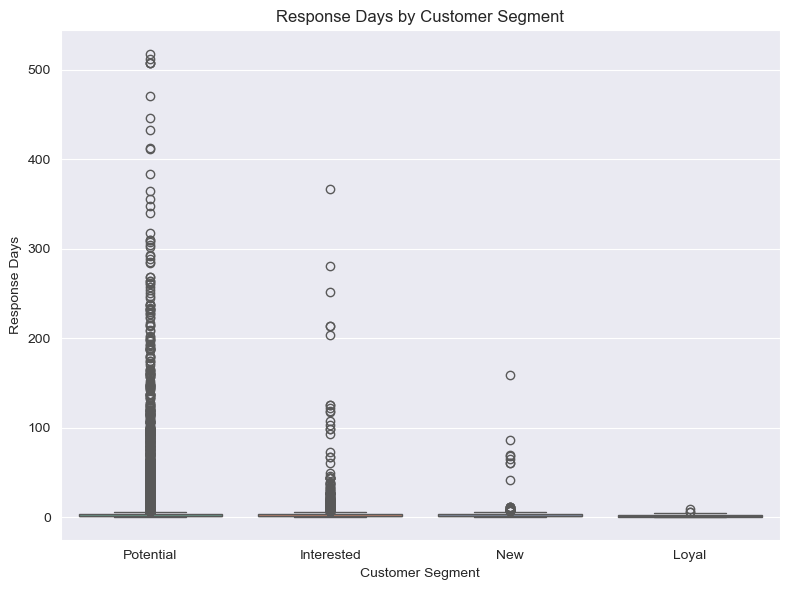

In [182]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=seg_df, x='seg', y='response_days', hue='seg', palette='Set2', legend=False)
plt.title('Response Days by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Response Days')
plt.tight_layout()
plt.show()

응답 소요시간과 만족도 간 피어슨 상관계수: 0.007


/Users/yun-iseo/miniconda3/envs/ai_basic_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51025 (\N{HANGUL SYLLABLE EUNG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yun-iseo/miniconda3/envs/ai_basic_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yun-iseo/miniconda3/envs/ai_basic_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yun-iseo/miniconda3/envs/ai_basic_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yun-iseo/miniconda3/envs/ai_basic_env/lib/python3.12/site-packages/IPython/core/pylabt

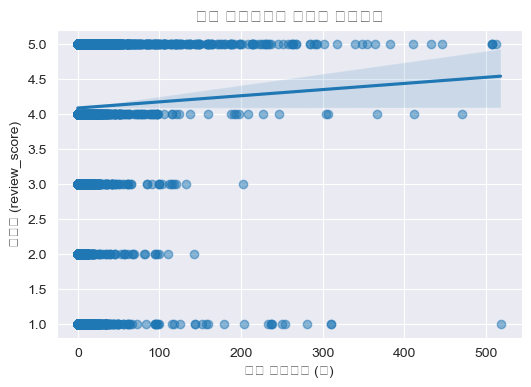

In [183]:
# 상관계수 계산 (피어슨)
corr = seg_df['response_days'].corr(seg_df['review_score'])
print(f"응답 소요시간과 만족도 간 피어슨 상관계수: {corr:.3f}")

# 산점도와 추세선 시각화
plt.figure(figsize=(6,4))
sns.regplot(x='response_days', y='review_score', data=seg_df, scatter_kws={'alpha':0.5})
plt.title('응답 소요시간과 만족도 상관관계')
plt.xlabel('응답 소요시간 (일)')
plt.ylabel('만족도 (review_score)')
plt.show()